In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import cgatcore.database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **MEME**
- Searches for **novel** ungapped motifs in input sequences
- TOMTOM compares discovered motifs against database(s) of known motifs

In [2]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [3]:
def motif_lookup(db):
    
    with open("./pipeline.yml", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [4]:
def meme_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.yml
    with open("./pipeline.yml", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")


            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                    
                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    if os.path.exists(meme_out):
                        n = 0
                        with open(meme_out, "r") as open_meme:
                            for line in open_meme:
                                motif = re.findall("^MOTIF.*", line)
                                if len(motif) > 0:
                                    n = n + 1
                                    nmotif = str(motif[0].split(" ")[0:3][-1])
                                e_val = re.findall("E-value.*", str(motif))
                                if len(e_val) > 0:
                                    e_value = e_val[0].split(" ")[-1].replace("'", "").strip("]")

                                if (len(e_val)>0) & (len(motif) > 0):
                                    df = pd.DataFrame([nmotif, e_value]).transpose()
                                    df.columns = ["query_id", "meme_evalue"]
                                    df["run"] = str(table).rstrip("_Meme_tomtom")
                                    dfs.append(df)
    c = 0
    for df in dfs:
        c = c + 1
        if c ==1:
            motifs = df
        else:
            motifs = motifs.append(df)

    motifs = motifs.drop_duplicates()
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("meme_motifs", connect, if_exists="replace", index=False)
                    
    return motifs

meme = meme_summary(db, conditions=["increase", "decrease"])

In [5]:
def memechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.yml
    with open("./pipeline.yml", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"

                    if tables["tables"].str.contains(table).any():

                        n = 0
                        for query in no_motifs:
                            n = n + 1
                            statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                        b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                        from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                        and a.query_id = %(query)s 
                                        order by e_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df = df.drop_duplicates()
                            df["run"] = str(table).rstrip("_Meme_tomtom")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                            if n == 1:
                                result = df
                            else:
                                result = result.append(df)

                        dfs.append(result)
                        
    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

motifs = memechip_summary(db, conditions=["increase", "decrease"])

In [6]:
def analyse_meme(motifs, meme):

    # annotate dfs for merging
    motifs["merge"] = motifs.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)
    meme["merge"] = meme.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)

    meme.drop(["query_id", "run"], axis=1, inplace=True) # drop extra cols

    # merge dfs
    meme_chip = pd.merge(meme, motifs, how="inner", on="merge")
    meme_chip.drop_duplicates(inplace=True)

    meme_chip["meme_evalue"] = meme_chip["meme_evalue"].apply(lambda x: float(x)) # correct type
    meme_chip["settings"] = meme_chip["no_peaks"] + "_" + meme_chip["window"] # make column for plot annotations

    if len(meme_chip[meme_chip["meme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        meme_chip = None

    else:
        # subset on sig motifs & sig matches
        meme_chip = meme_chip[(meme_chip.tomtom_evalue < 0.05) & (meme_chip.meme_evalue < 0.05)].sort_values(["meme_evalue", "tomtom_evalue"], ascending=True)
        meme_chip = meme_chip[meme_chip["meme_evalue"] != 0]
        meme_chip = meme_chip[meme_chip["tomtom_evalue"] != 0]

    return meme_chip

meme_chip = analyse_meme(motifs, meme)

## Effect of MEME-ChIP Settings on MEME & TOMTOM

In [7]:
# make new df for plots
meme_evalue = meme_chip.copy(deep=True)
meme_evalue.index.name = None
meme_evalue.reset_index(inplace=True, drop=True)
meme_evalue = meme_evalue.drop_duplicates(["target_id", "motif_name", "merge"], keep="first")

In [8]:
%%R  -w 1200 -h 400 -i meme_evalue

# meme_chip <- read.csv("meme_chip_summary.txt", sep="\t", row.names=1)

a <- ggplot(meme_evalue, aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), shape=factor(query_id), alpha=condition, colour=database)) +
        geom_jitter(size=3) + 
        scale_alpha_discrete(range=c(0.4, 1)) +
        facet_grid(settings ~ DESeq2_comparison) +
        theme(legend.position="bottom", legend.direction="horizontal")
        
b <- ggplot(meme_evalue, aes(y=-log10(meme_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=meme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Meme motif discovery", x="Peak width")
        
c <- ggplot(meme_evalue, aes(y=-log10(tomtom_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=meme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif comparison", x="Peak width")

In [9]:
meme_motif_no = meme_evalue.groupby(["run", "window", "no_peaks"]).agg({"motif_name":"count"})
meme_motif_no.reset_index(inplace=True)

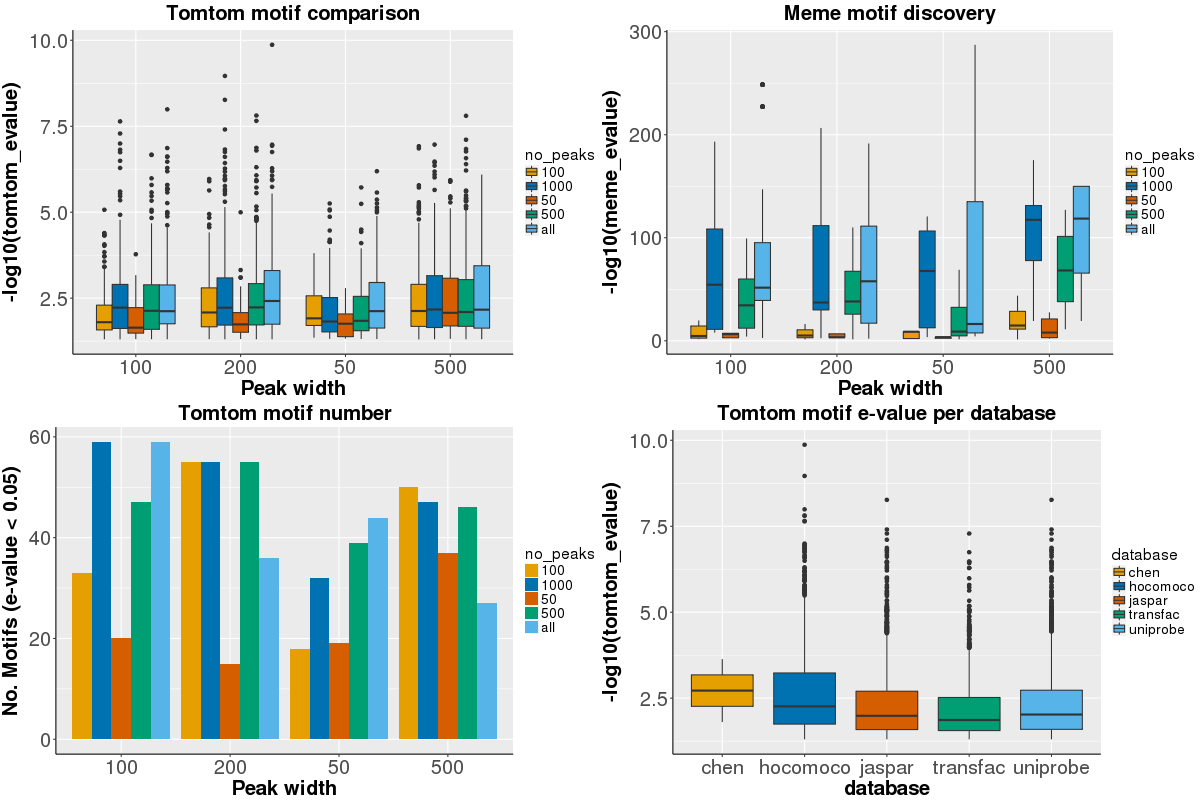

In [10]:
%%R -i meme_motif_no,meme_chip -w 1200 -h 800

# meme_motif_no <- meme_motif_no[order(meme_motif_no$motif_name, descending=TRUE), ]
d <- ggplot(meme_motif_no, aes(y=motif_name, x=window, fill=no_peaks)) + 
        geom_bar(stat="identity", position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif number", x="Peak width", y="No. Motifs (e-value < 0.05)")# +
#         scale_x_discrete(limits=unique(meme_motif_no$window))
        
e <- ggplot(meme_chip, aes(y=-log10(tomtom_evalue), x=database, fill=database)) + 
        geom_boxplot() +
        scale_fill_manual(values=Palette) +
        labs(title="Tomtom motif e-value per database")
        
grid.arrange(c, b, d, e, ncol=2, nrow=2)

## MEME-ChIP Summary
* For simplicity results from all MEME-ChIP runs are aggregated
    * TOMTOM & MEME e-values are averaged across runs
    * No. motif occurances between runs and databases is counted
    * All MEME motifs have an e-value < 0.05
* This is to provide an overview of the data, do not use for downstream analysis

In [11]:
# aggregate data
meme_summary = meme_chip.groupby(["target_id", "motif_name", "query_id", "DESeq2_comparison", "condition"]).agg({"tomtom_evalue":"mean", "meme_evalue":"mean", "run":"count", "database":"count"})
meme_summary.reset_index(inplace=True)

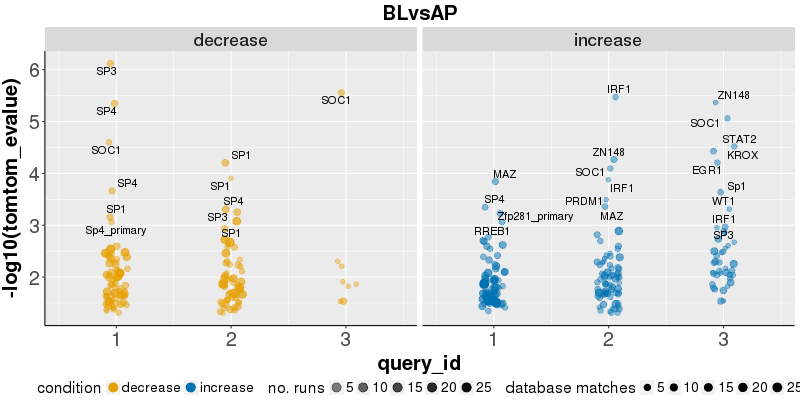

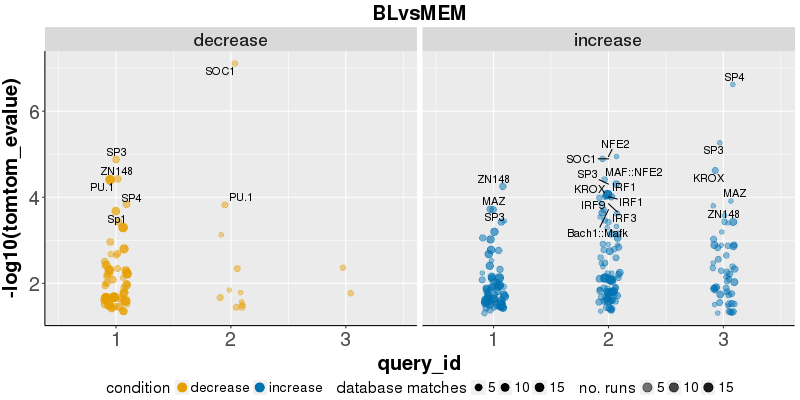

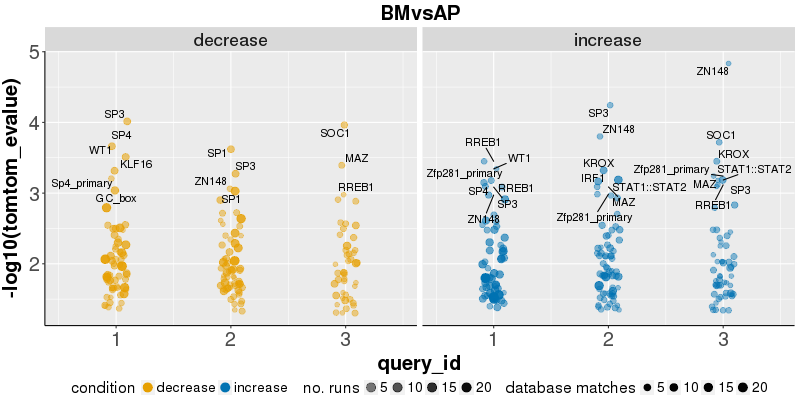

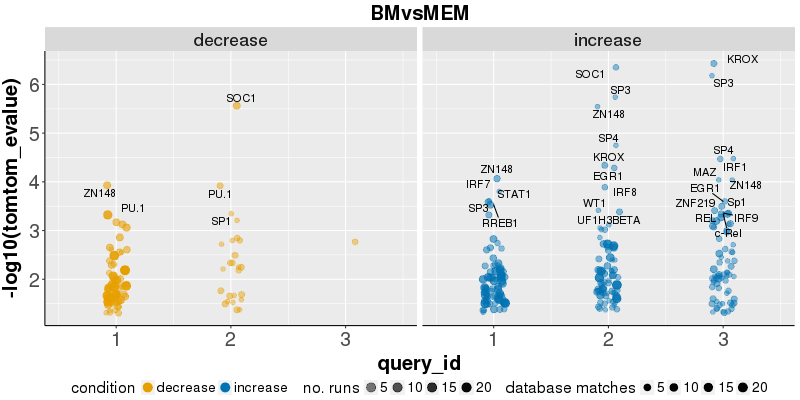

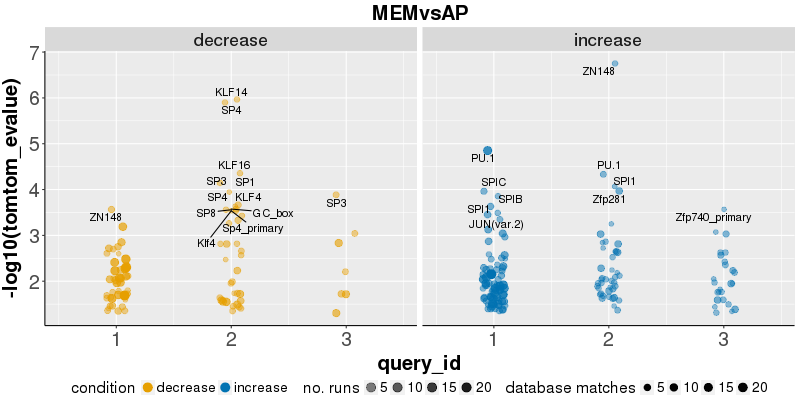

In [12]:
%%R -i meme_summary -w 800 -h 400

for (comp in unique(meme_summary$DESeq2_comparison)){

    df <- subset(meme_summary, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=query_id, alpha=run, colour=condition)) +
            geom_point(aes(size=database), position=position_jitterdodge()) + 
            scale_size(range=c(2,4), name="database matches") +
            scale_alpha(range=c(0.4,1), name="no. runs") +
            scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
            geom_text_repel(
                data=df[-log10(df$tomtom_evalue) > 
                          quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                aes(label=motif_name), colour="black", alpha=1, position=position_jitterdodge()) +
            facet_wrap(~ condition) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            scale_colour_manual(values=Palette) +
            guides(color=guide_legend(override.aes=list(size=4)), alpha=guide_legend(override.aes=list(size=4))) +
            labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

## MEME & TOMTOM Results for Each Run & Sample
* Multiple database hits for the same motif discovered by MEME are merged (TOMTOM e-values are averaged)

In [13]:
# make new df for plot
meme_graph = meme_chip.copy(deep=True)

# count occurnaces of the same motif matching a TF in many databases
# average tomtom_evalue in these instances
meme_graph = meme_graph.groupby(["merge", "target_id", "motif_name", "query_id","orientation", "run", "DESeq2_comparison", "condition", "settings"]).agg({"database":"count", "meme_evalue":"min", "tomtom_evalue":"mean"})
meme_graph.reset_index(inplace=True)

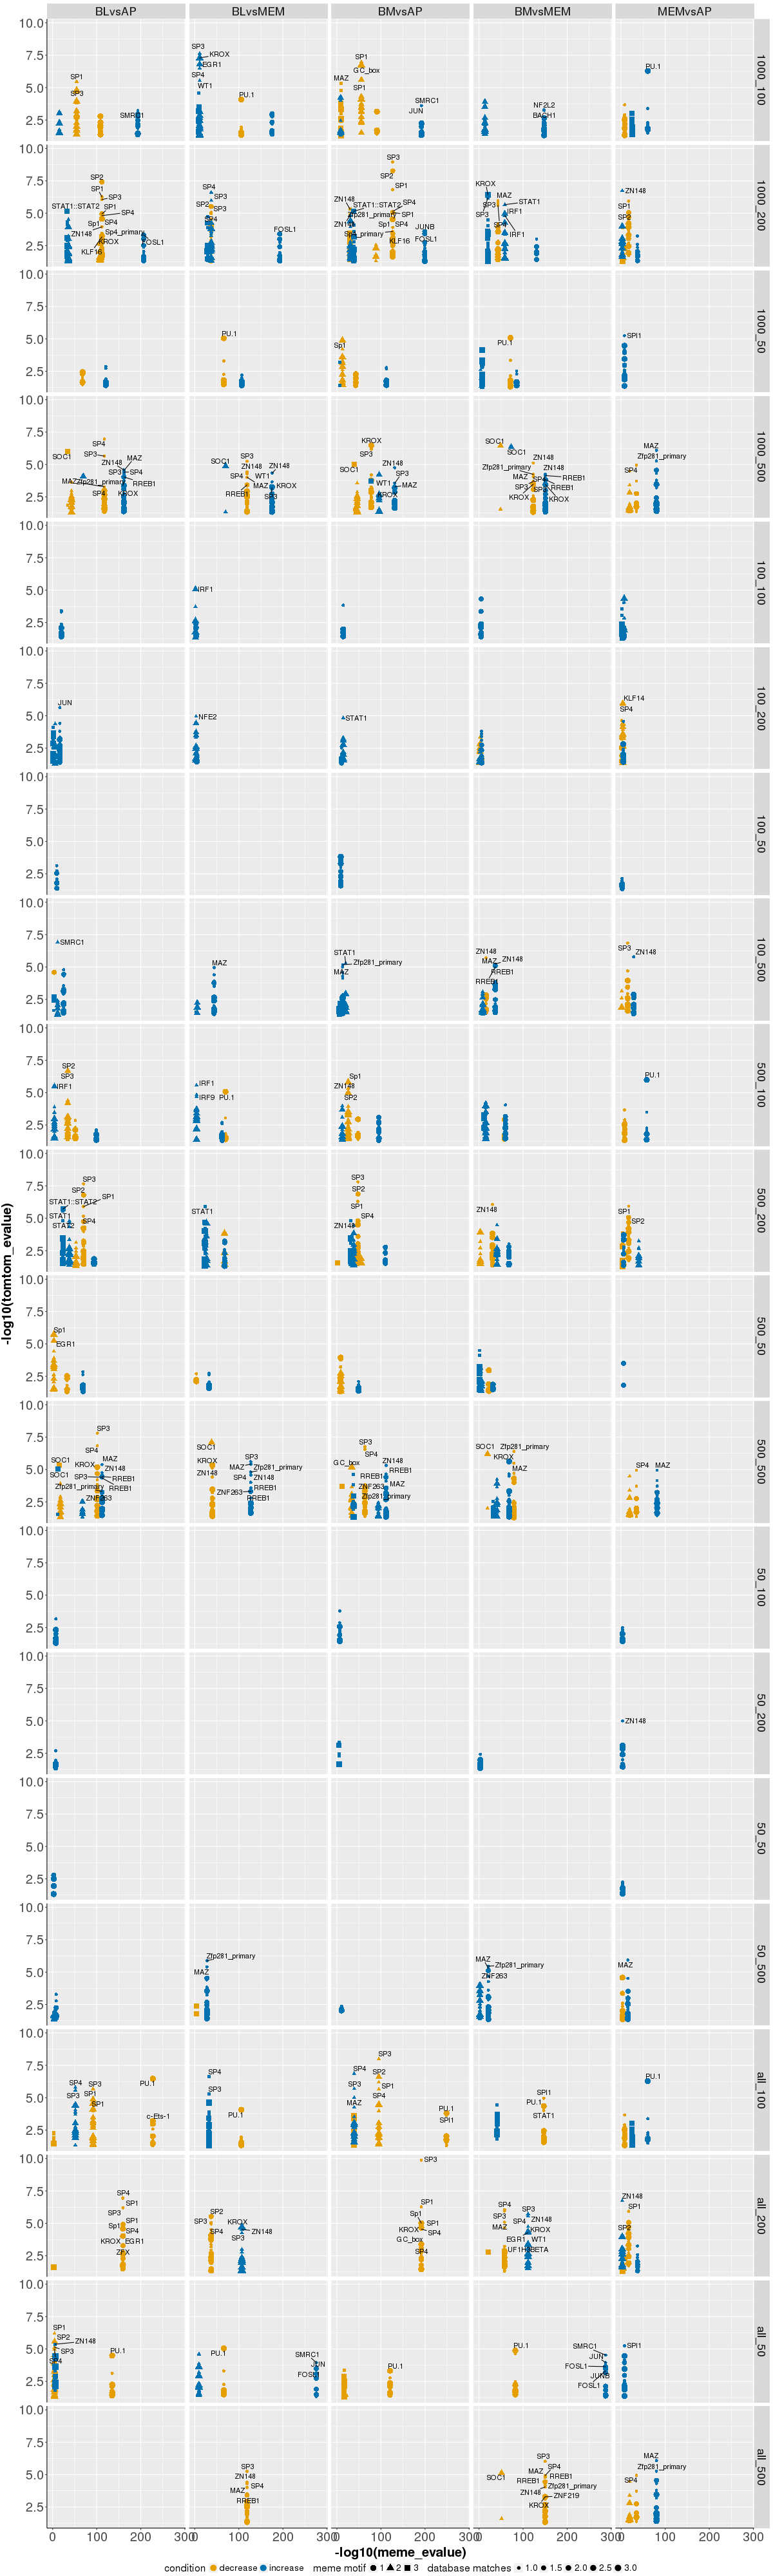

In [14]:
%%R -i meme_graph -w 1200 -h 4000

ggplot(meme_graph, aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), shape=factor(query_id), colour=condition)) +
    geom_jitter(aes(size=database)) + 
    scale_size(range=c(2,4), name="database matches") +
    scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
    geom_text_repel(data=meme_graph[-log10(meme_graph$"meme_evalue") > 
                                   quantile(-log10(meme_graph$"meme_evalue"), 0.8, na.rm=T) &
                                   -log10(meme_graph$"tomtom_evalue") > 
                                   quantile(-log10(meme_graph$"tomtom_evalue"), 0.8, na.rm=T) |#, ], 
                                   -log10(meme_graph$"meme_evalue") > quantile(-log10(meme_graph$"meme_evalue"), 0.95, na.rm=T)  &
                                   -log10(meme_graph$"tomtom_evalue") > 
                                   quantile(-log10(meme_graph$"tomtom_evalue"), 0.9, na.rm=T) |
                                   -log10(meme_graph$"tomtom_evalue") > quantile(-log10(meme_graph$"tomtom_evalue"), 0.95, na.rm=T), ], 
                    aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), label=motif_name), colour="black") +
    facet_grid(settings ~ DESeq2_comparison) +
    theme(legend.position="bottom", legend.direction="horizontal") +
    scale_colour_manual(values=Palette) +
    guides(color=guide_legend(override.aes=list(size=4))) +
    guides(shape=guide_legend(override.aes=list(size=4)))

### Top Database Matches per MEME Motif 
* All discovered motifs have e-value < 0.05
* Multiple database matches for MEME motifs are grouped by TF name & TOMTOM e-values averaged

In [15]:
# make extra cols for annotation
meme_graph["width"] = meme_graph["settings"].apply(lambda x: "width_" + x.split("_")[1])
meme_graph["peaks"] = meme_graph["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])

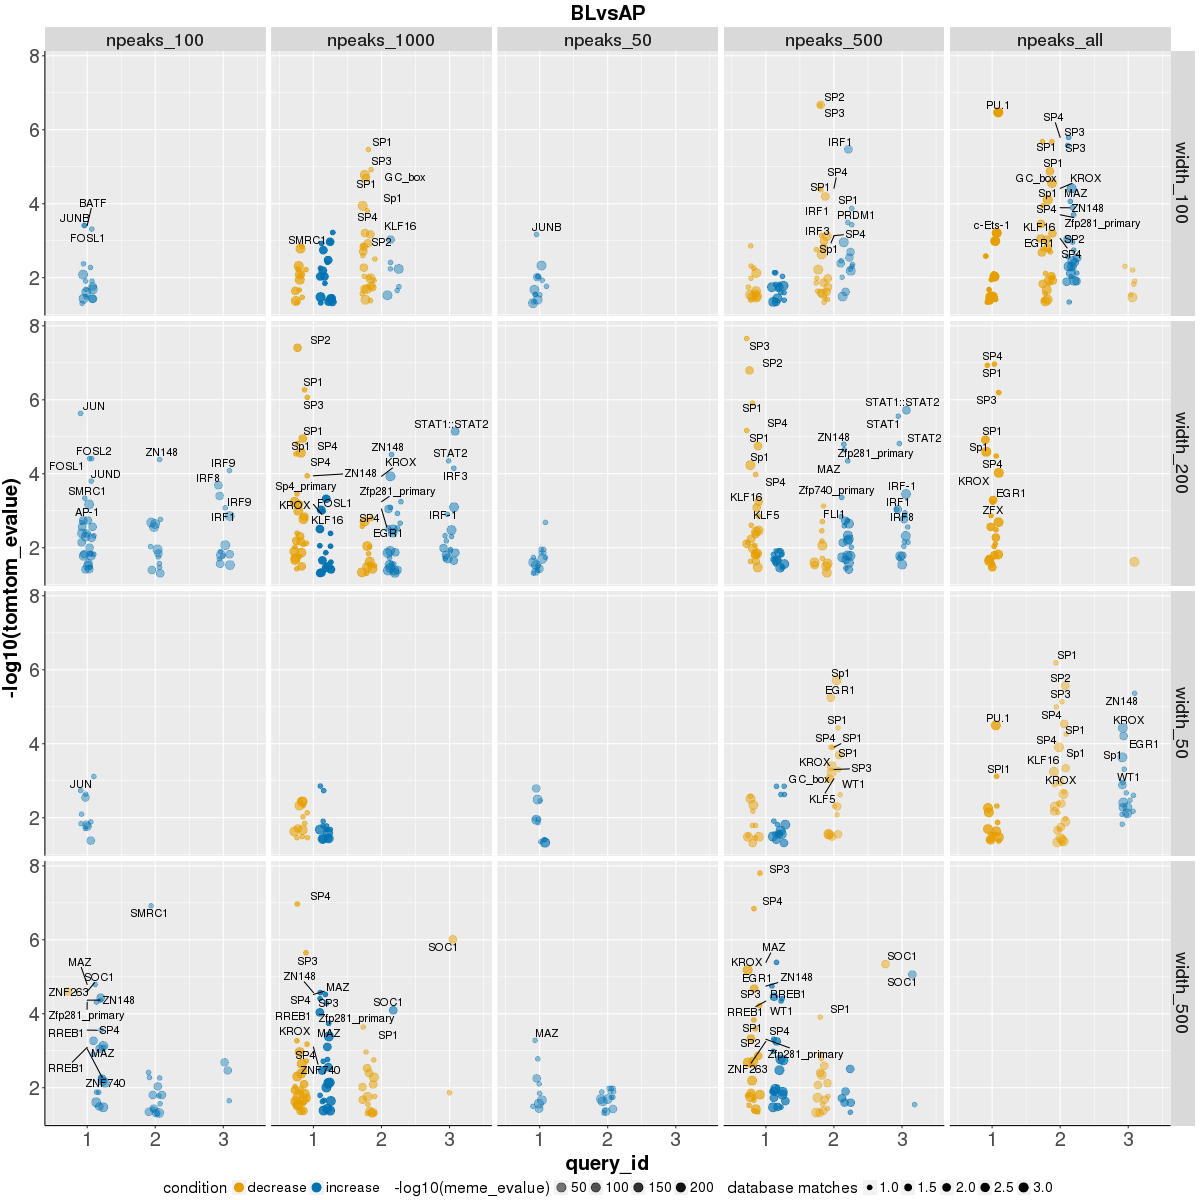

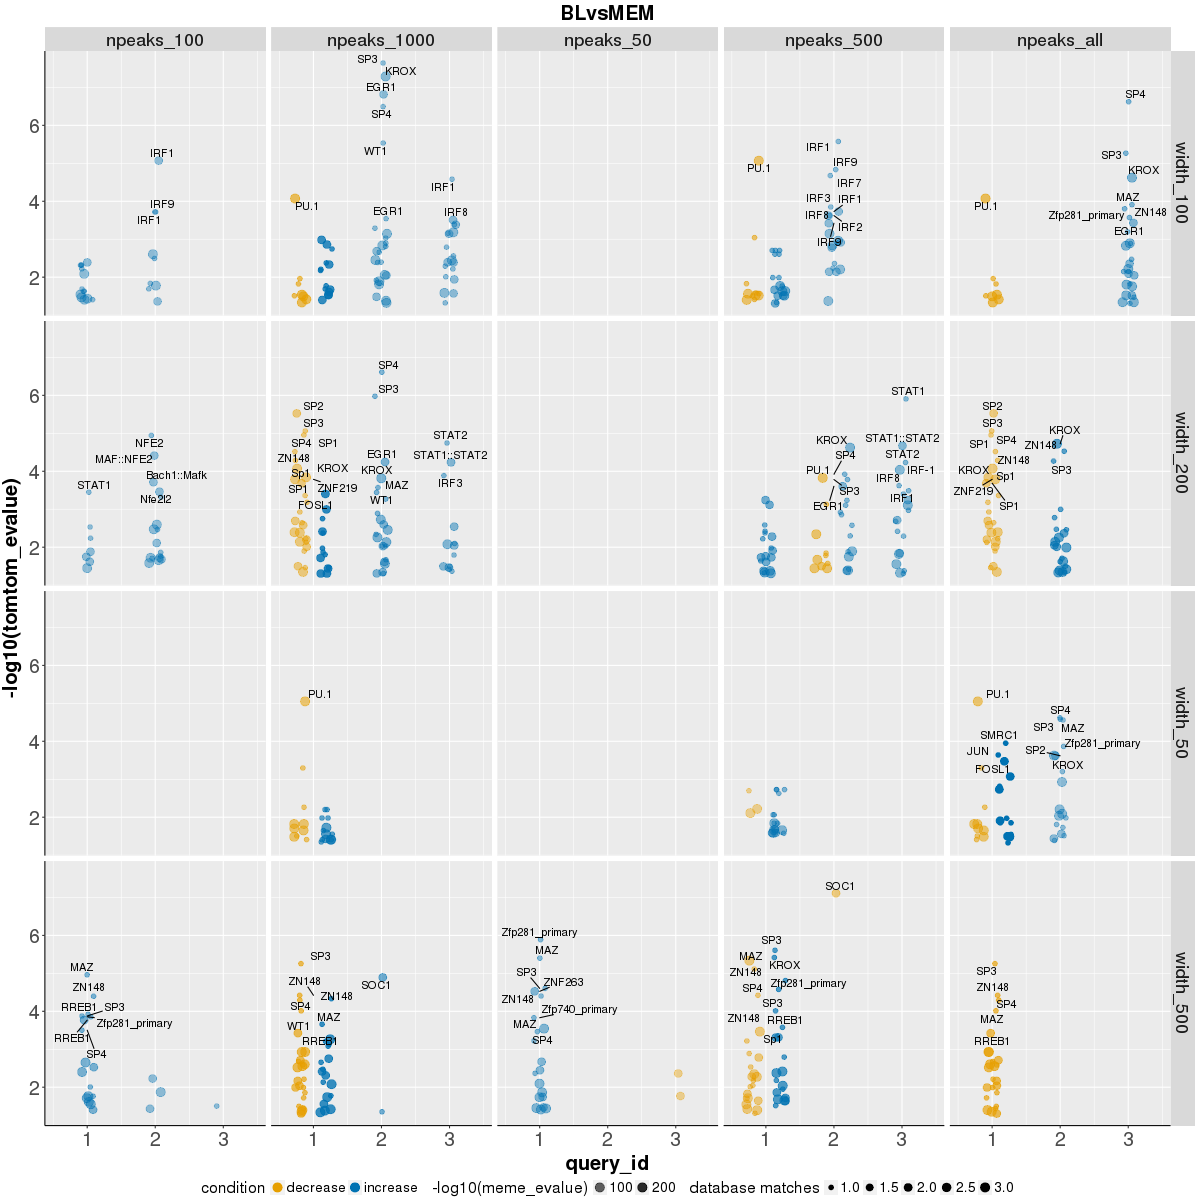

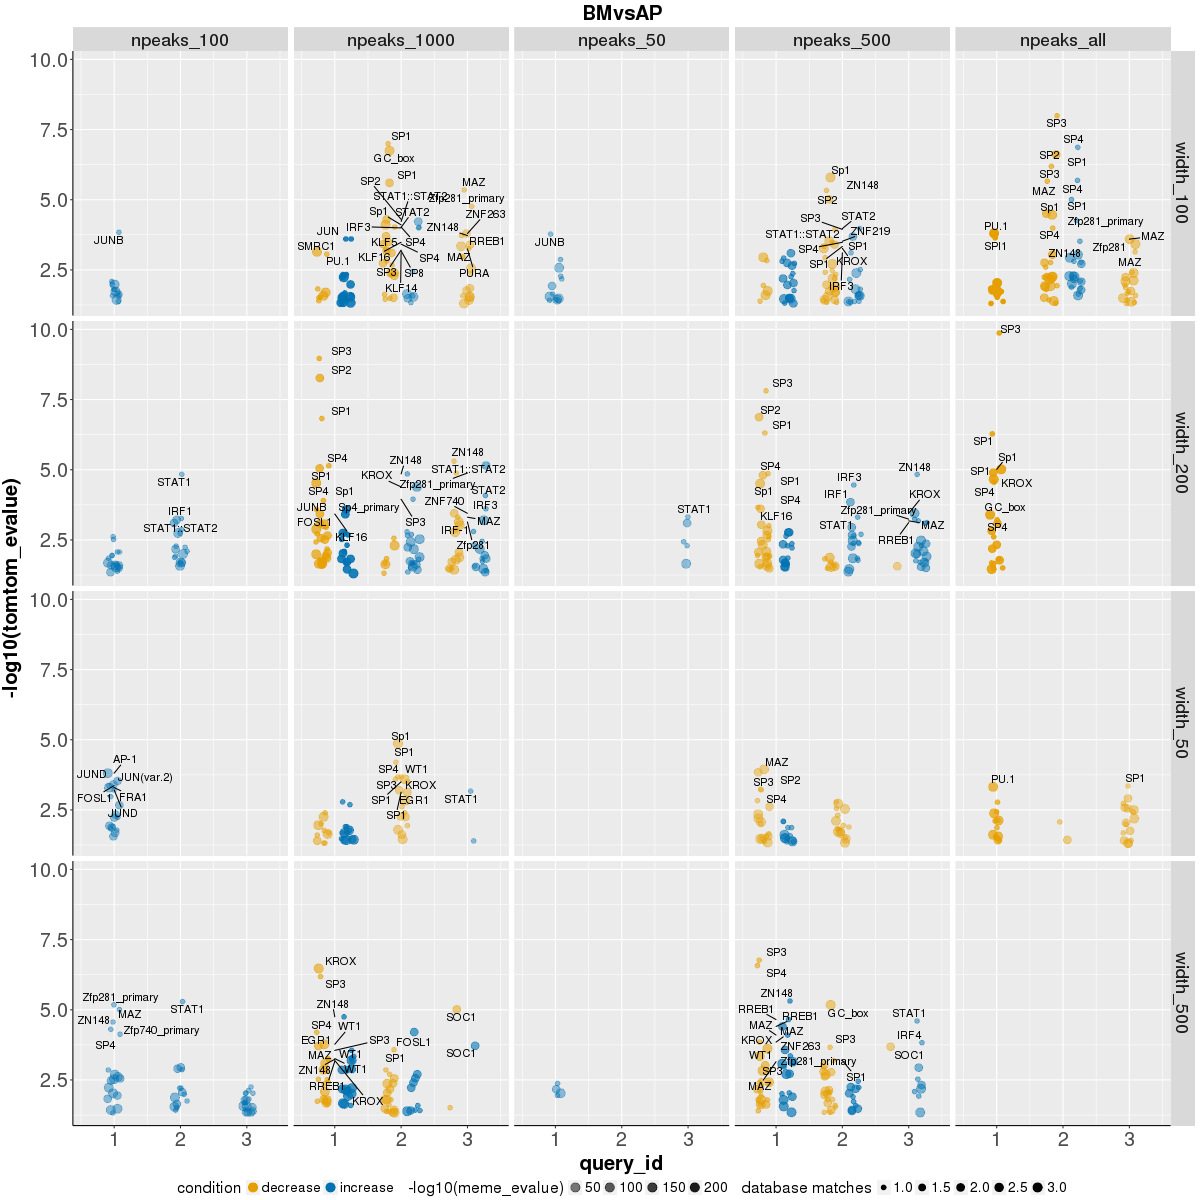

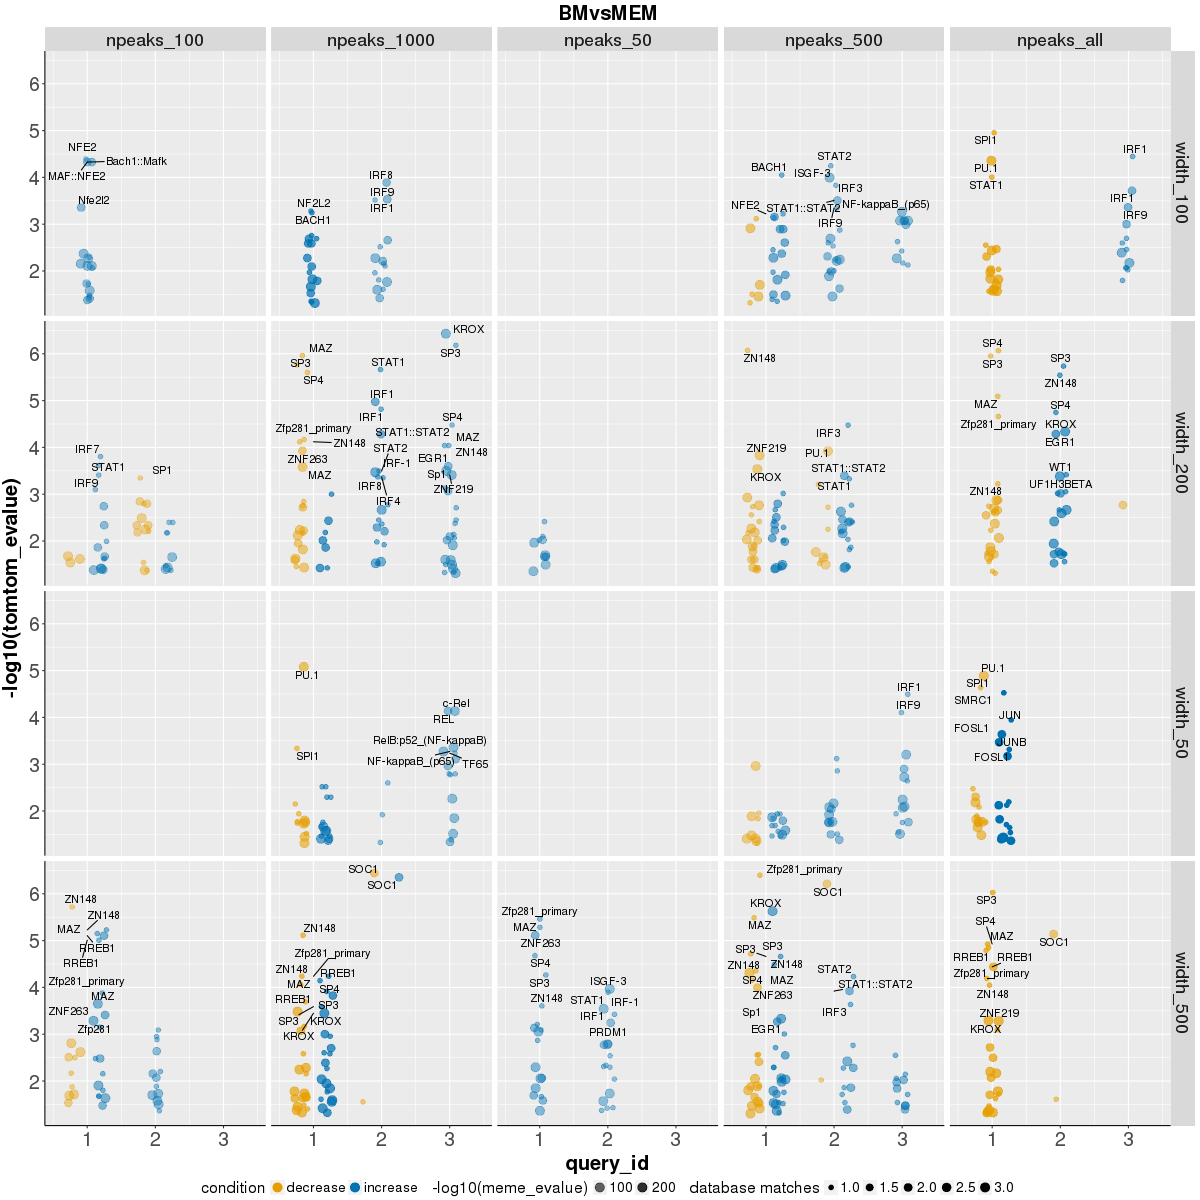

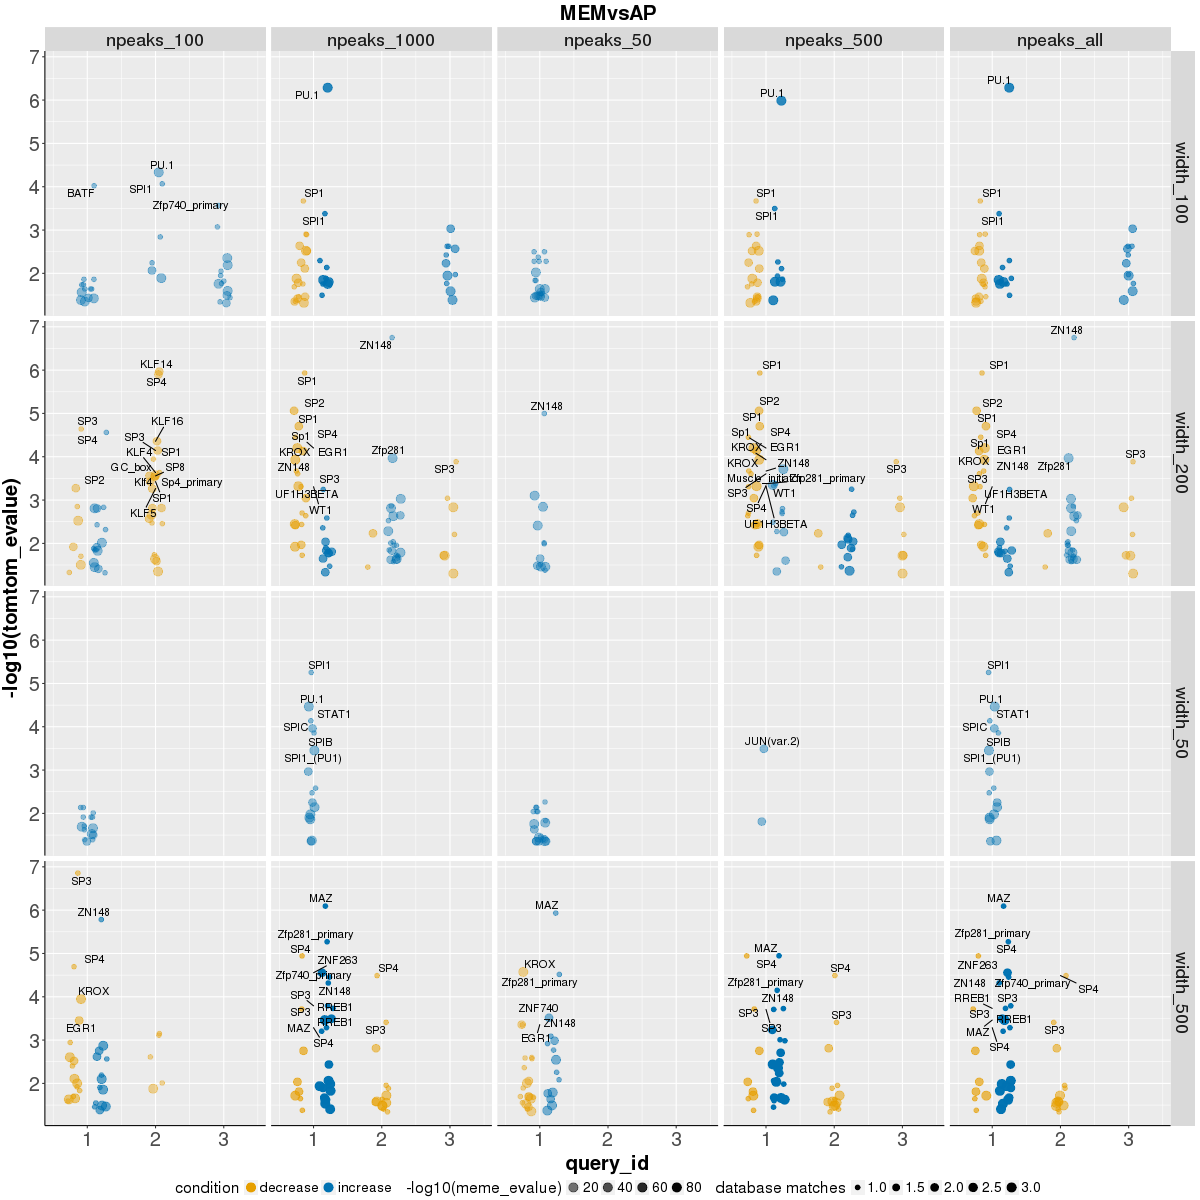

In [16]:
%%R -i meme_graph -w 1200 -h 1200

for (comp in unique(meme_graph$DESeq2_comparison)){
    df <- subset(meme_graph, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=query_id, alpha=-log10(meme_evalue), colour=condition)) +
        geom_point(aes(size=database), position=position_jitterdodge()) + 
        scale_size(range=c(2,4), name="database matches") +
        scale_alpha(range=c(0.4,1)) +
        geom_text_repel(data=df[-log10(df$"tomtom_evalue") > 
                                       quantile(-log10(df$"tomtom_evalue"), 0.8, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=query_id, label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=4))) +
        guides(alpha=guide_legend(override.aes=list(size=4)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

<br>
### Top TF Hits for Discovered Motifs 
- For significant motifs the top 5 significant TF matches are shown

In [54]:
tfs = meme_chip.groupby(["merge", "query_id", "DESeq2_comparison", "meme_evalue", "tomtom_evalue", "settings"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs["query_id"] = tfs["query_id"].astype(str)
tfs = tfs.groupby("merge").head(5) # get top 5 db matches for each discovered motif

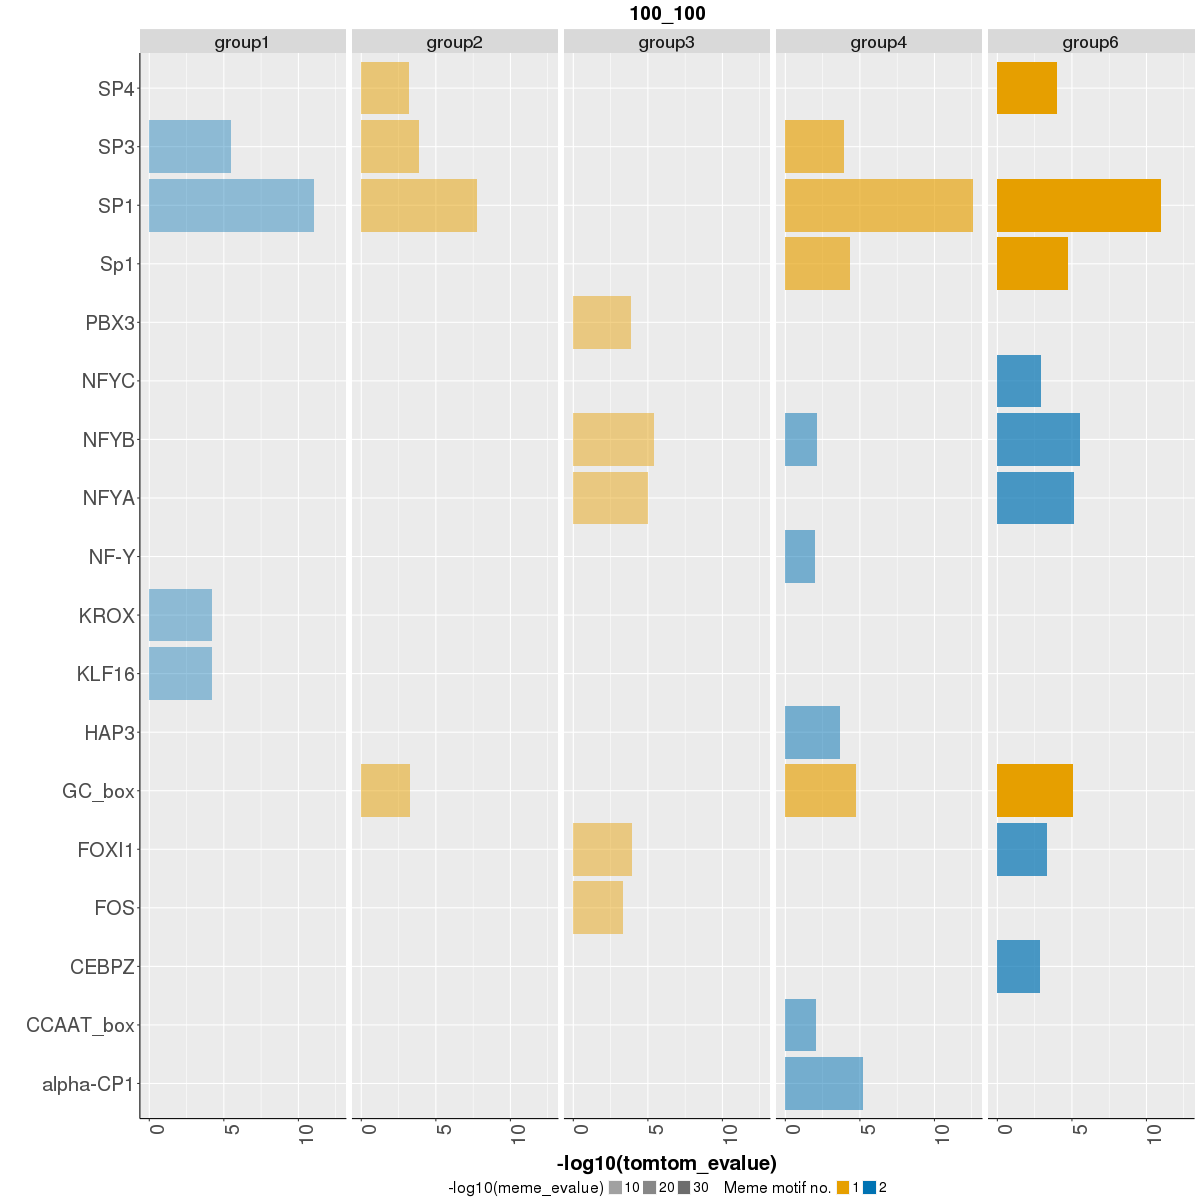

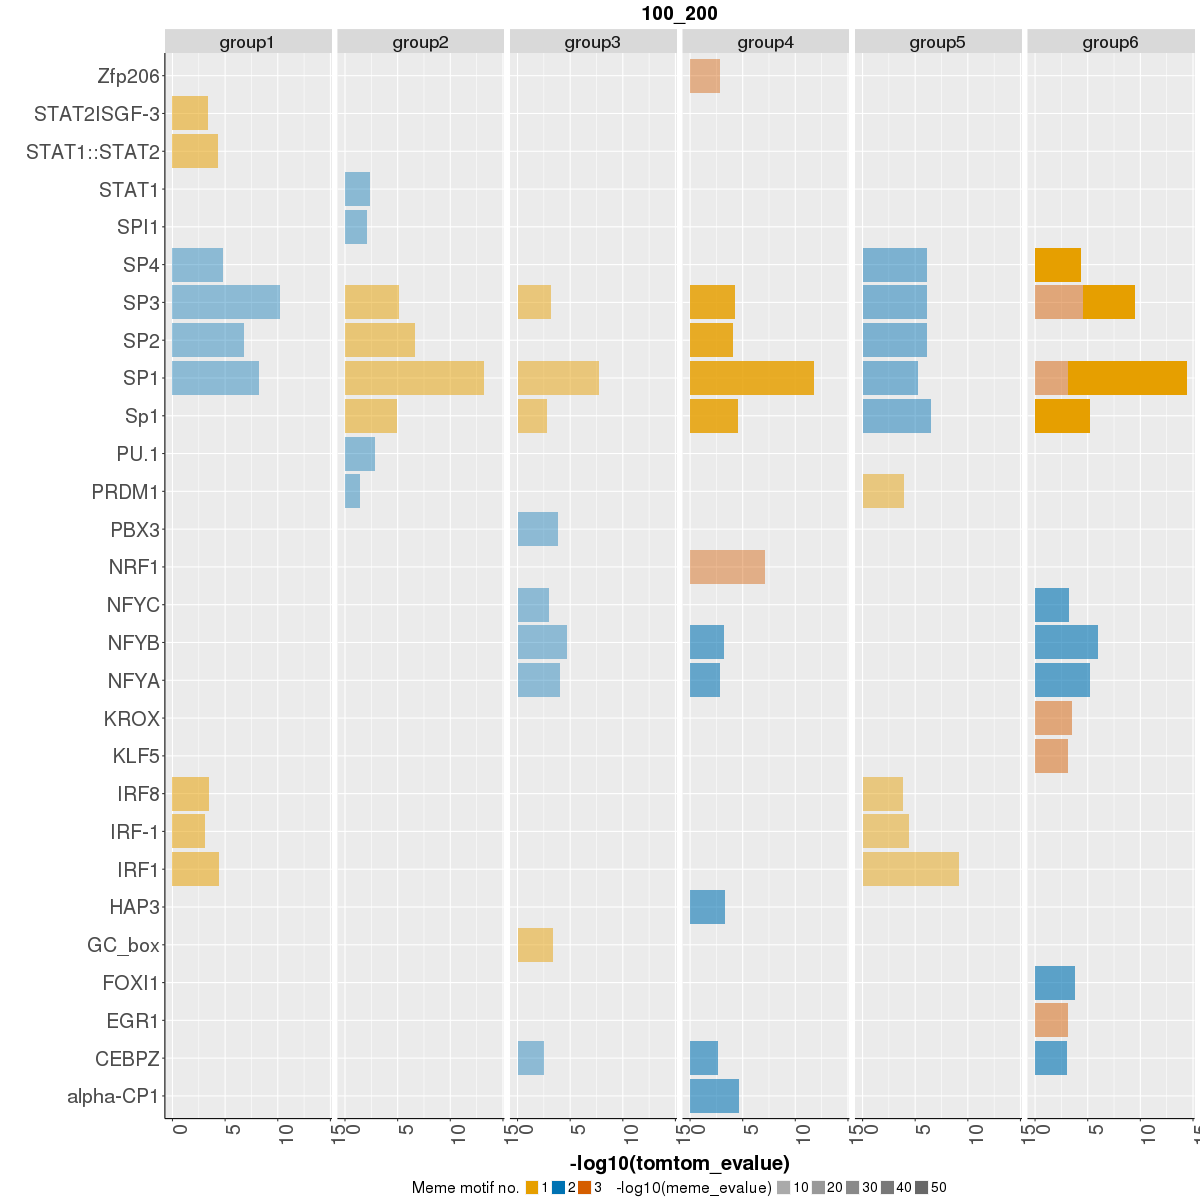

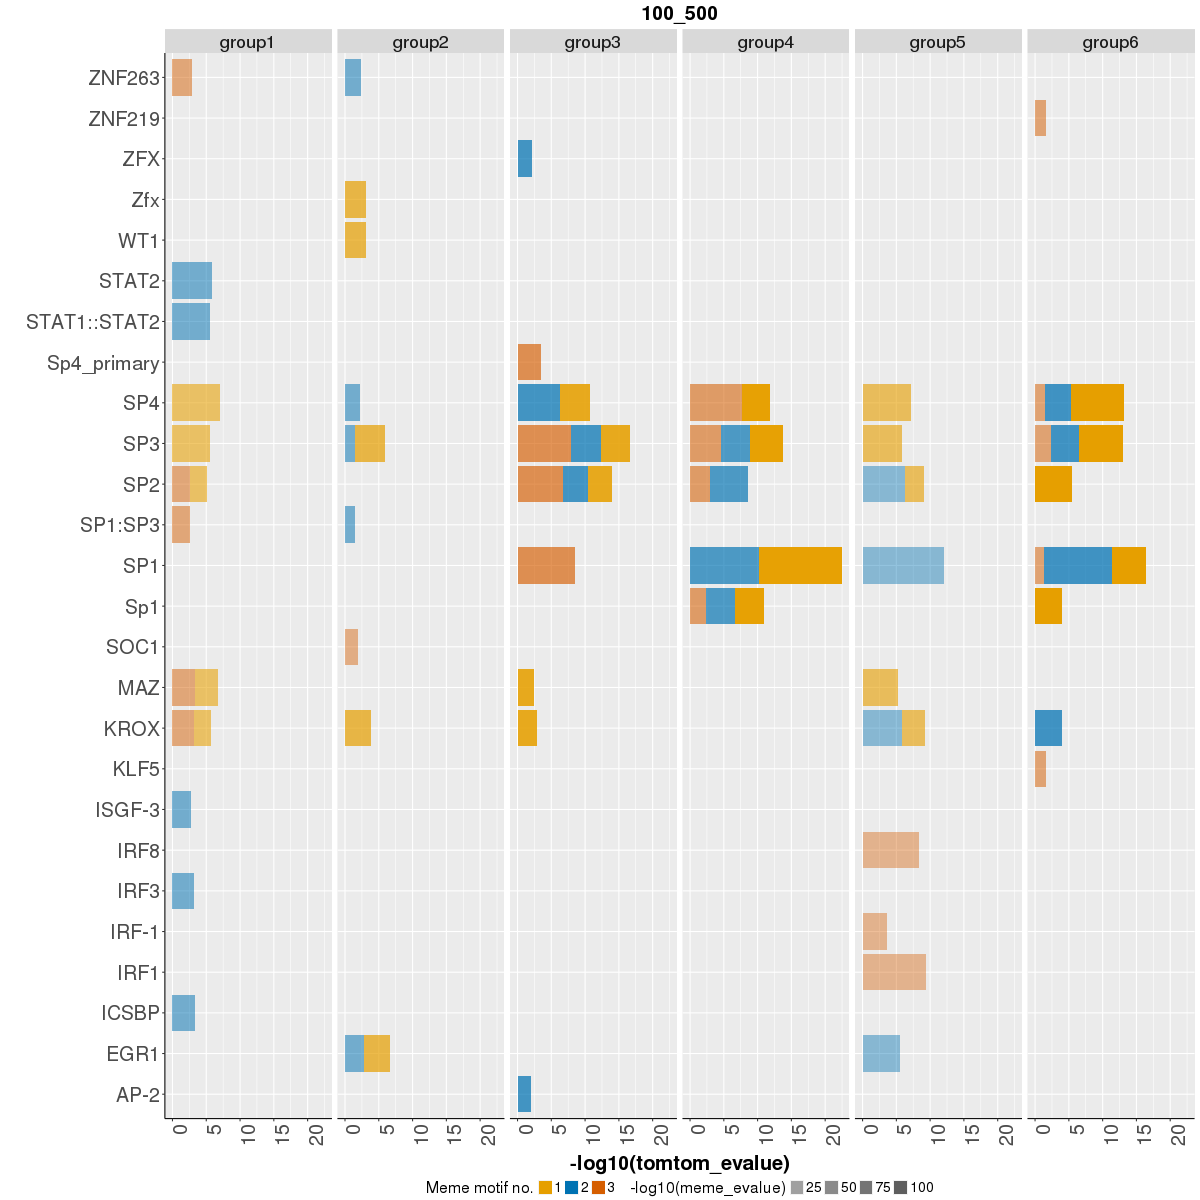

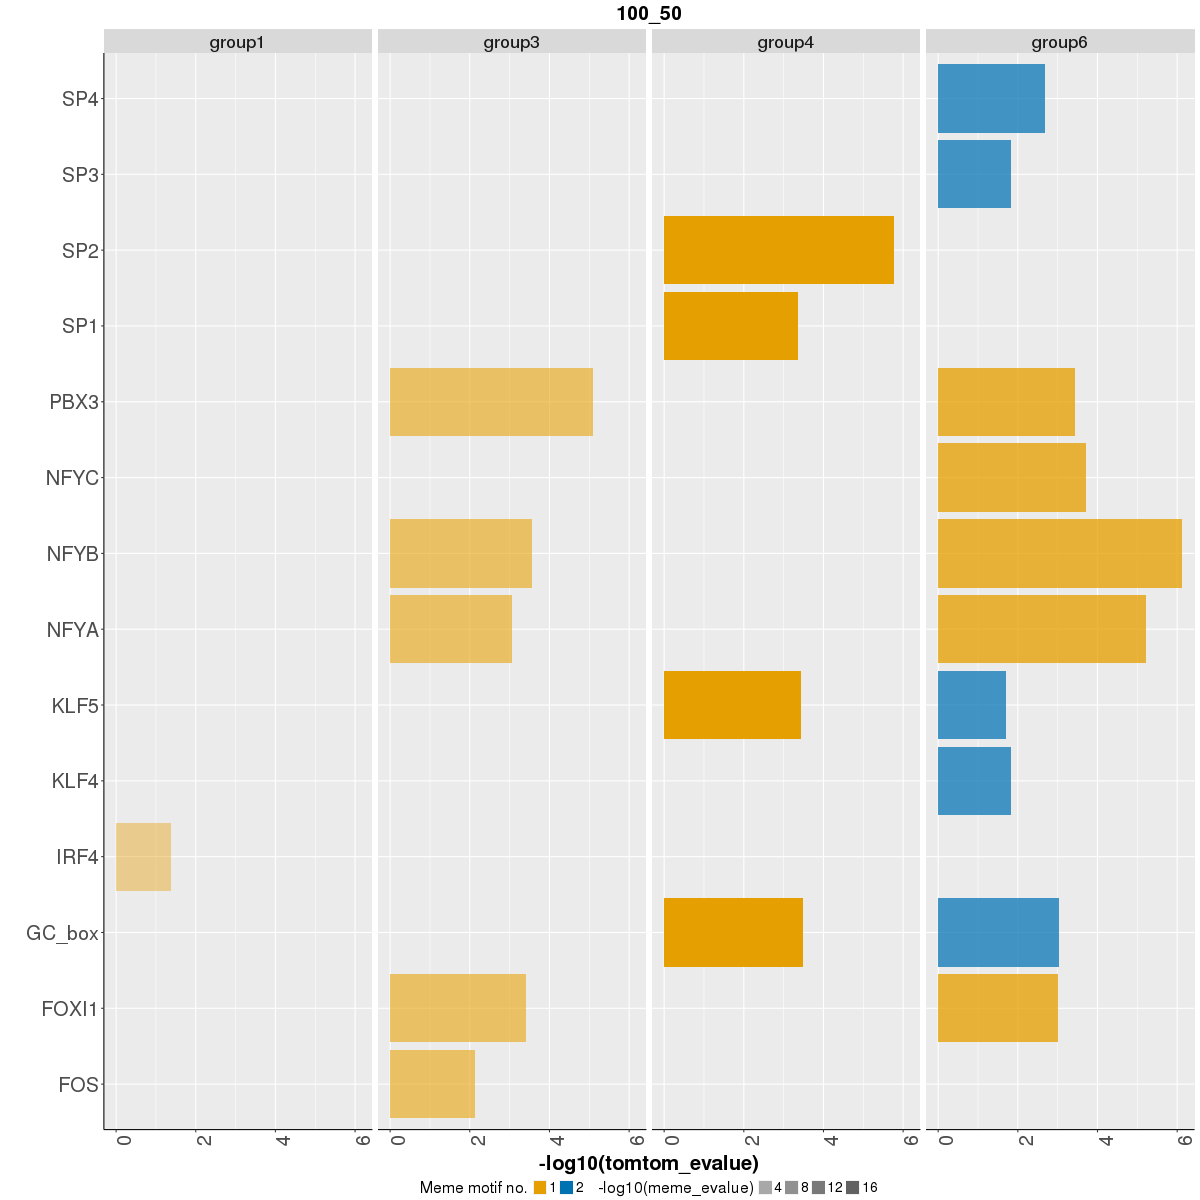

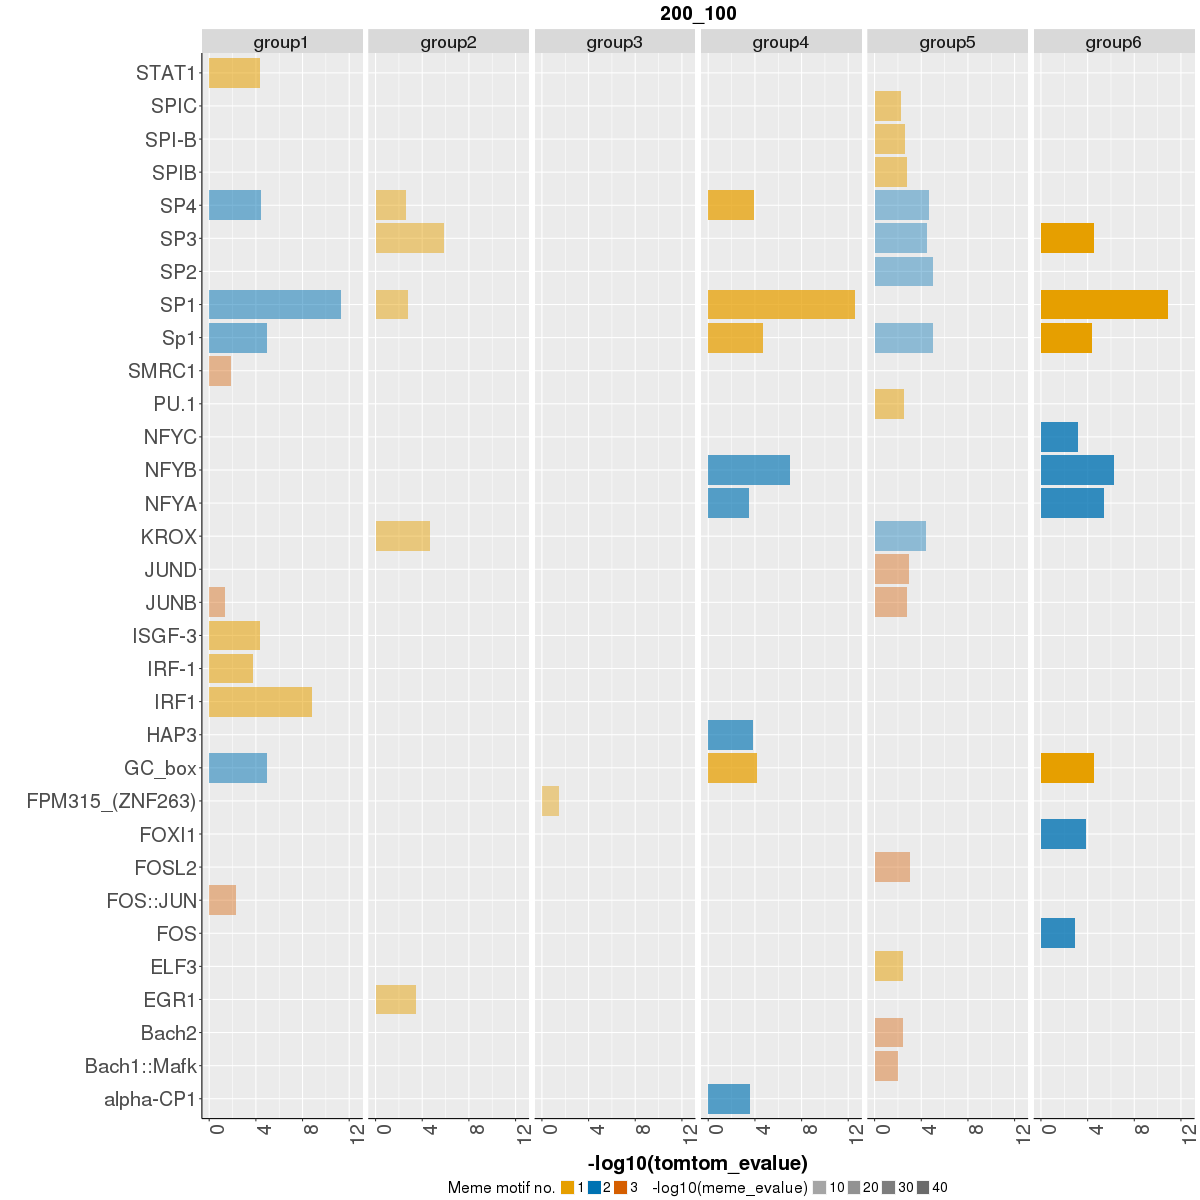

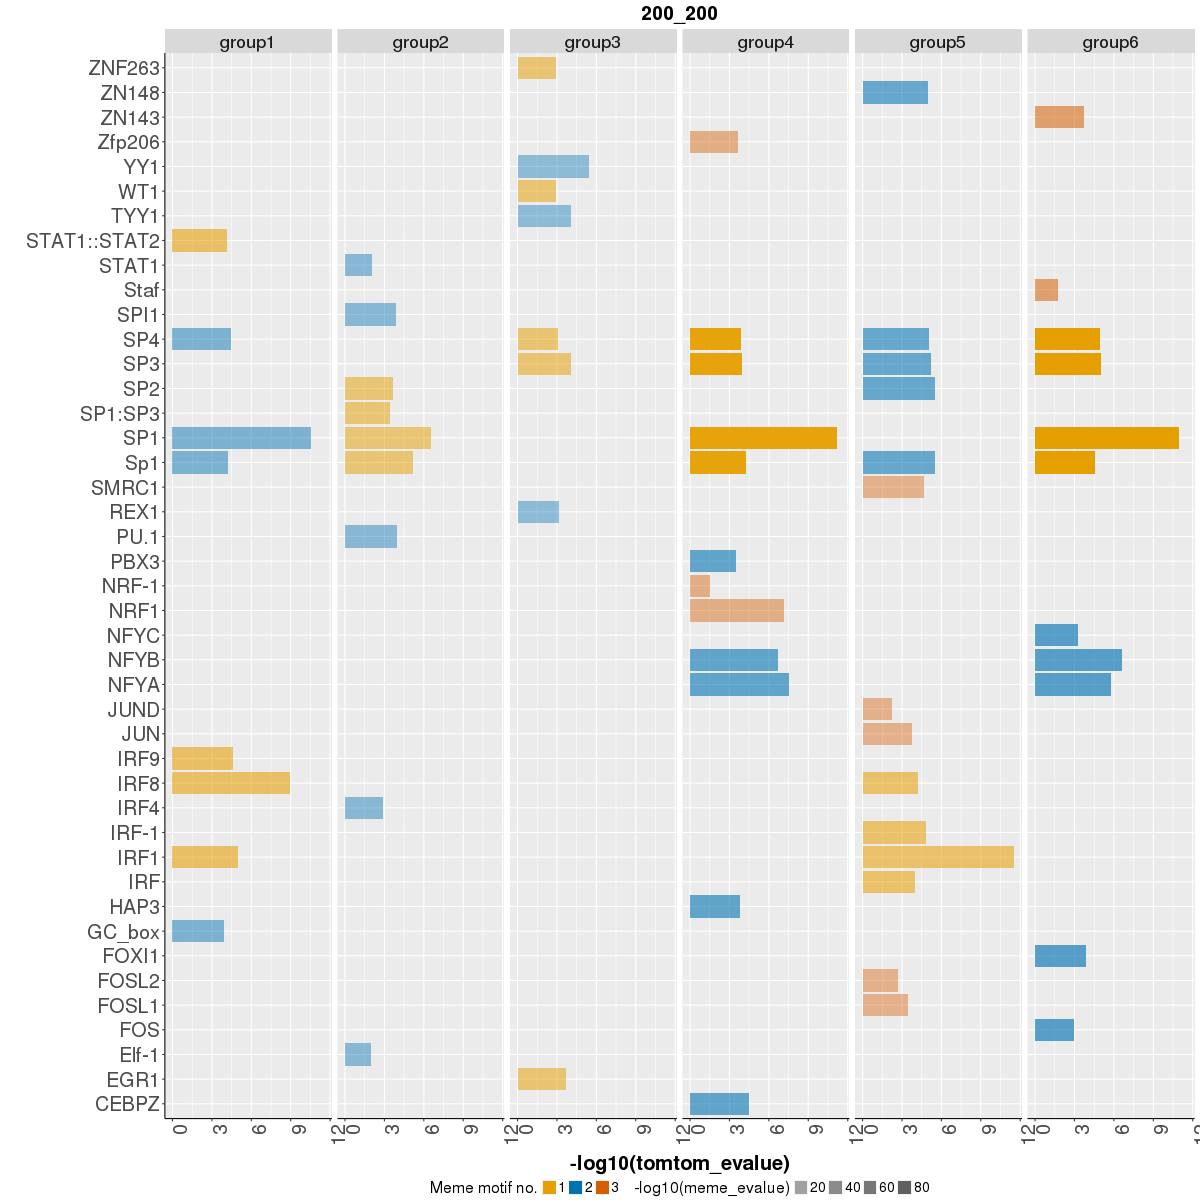

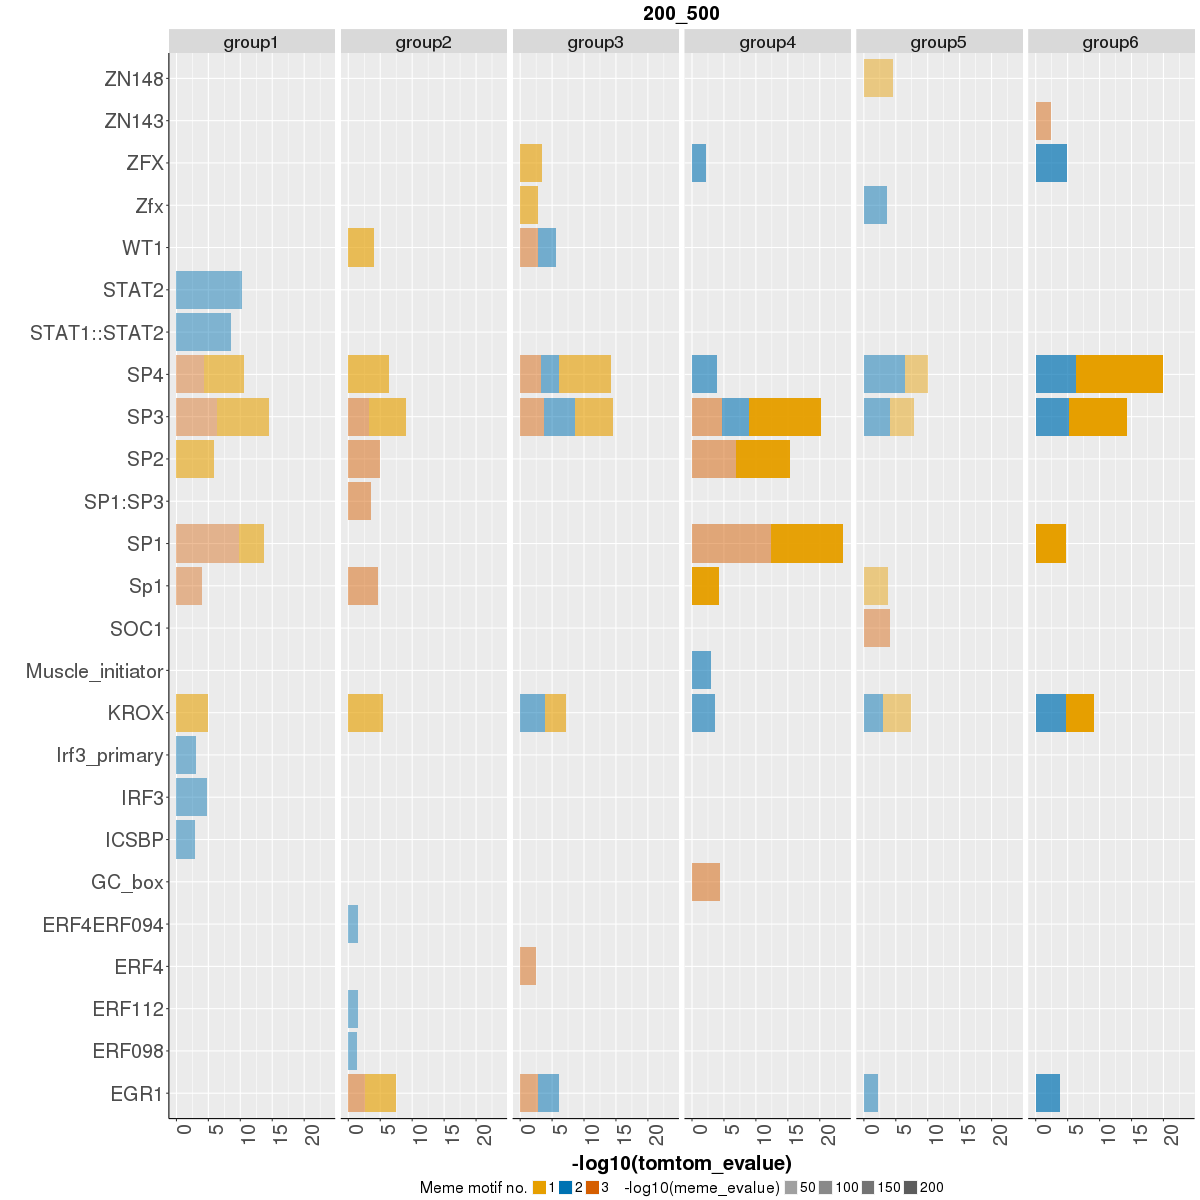

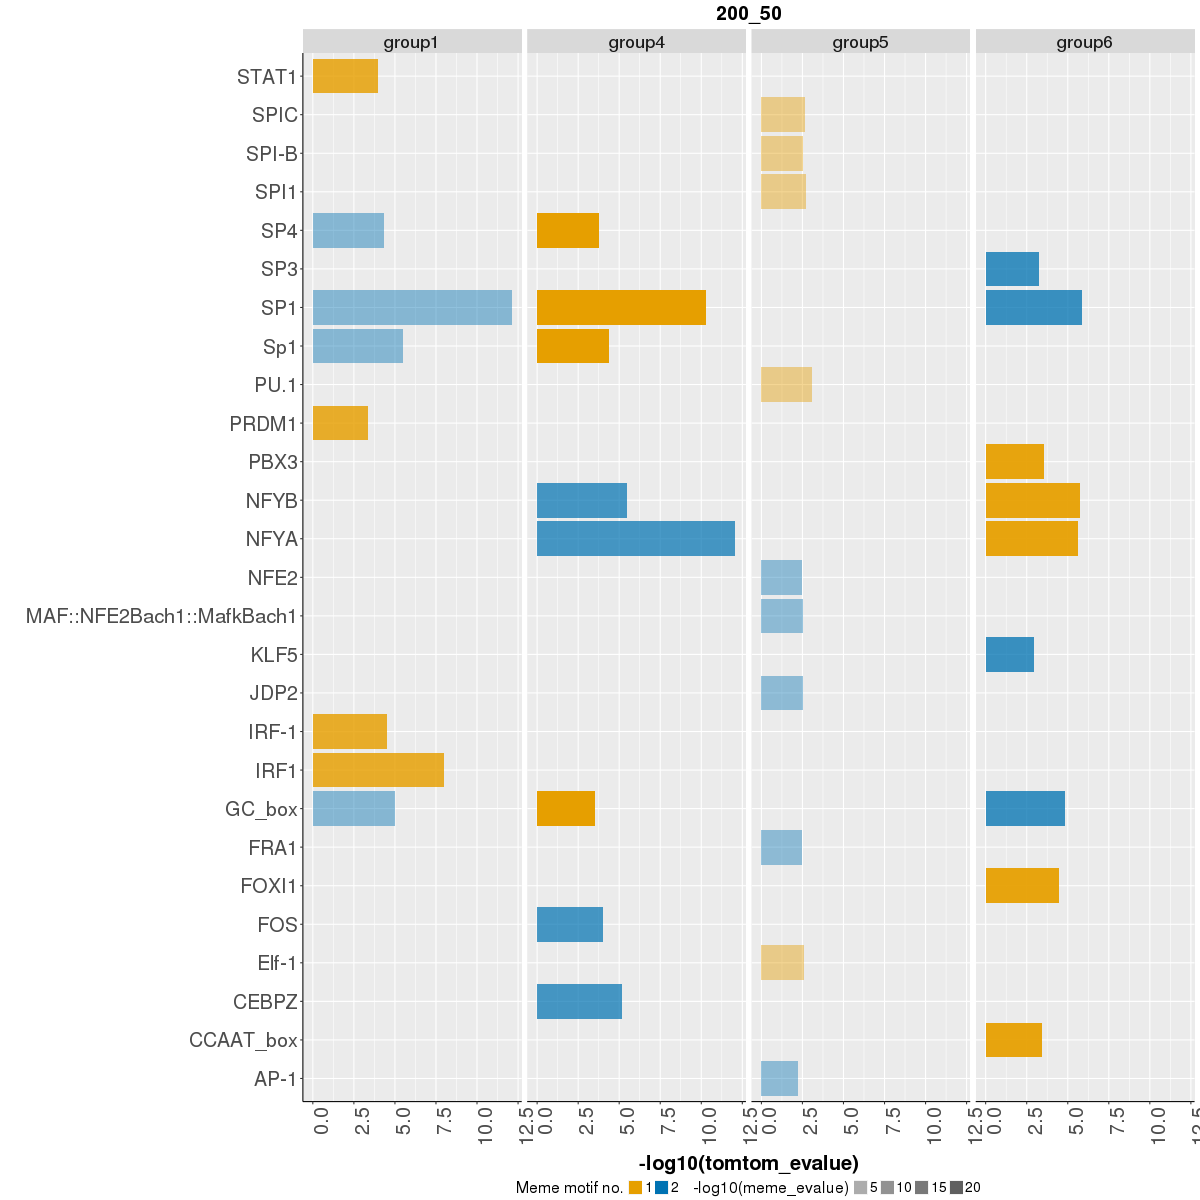

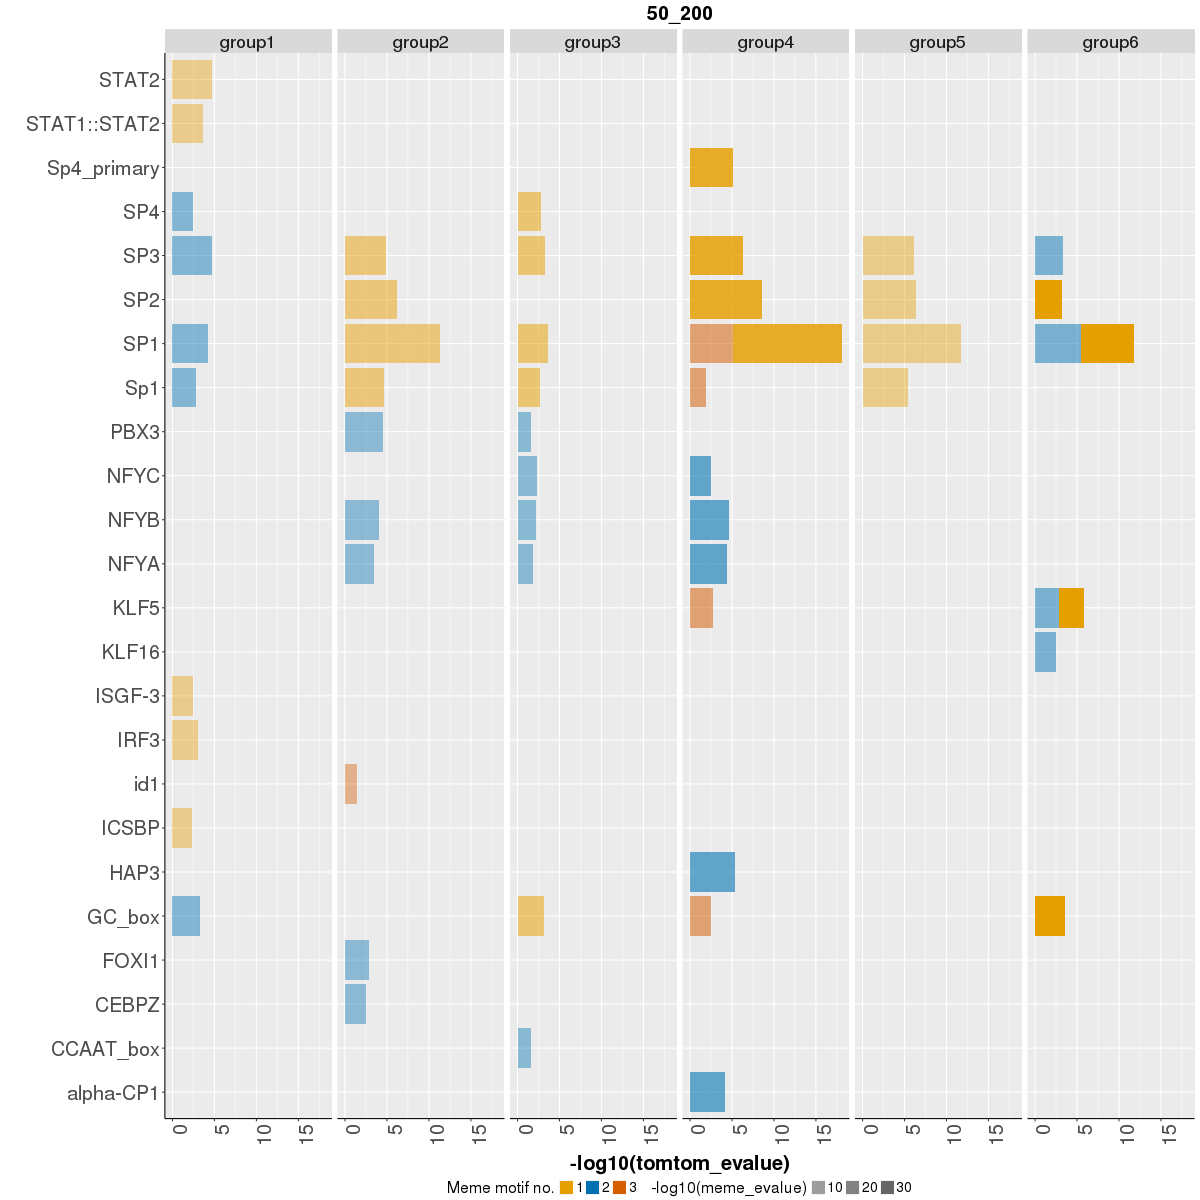

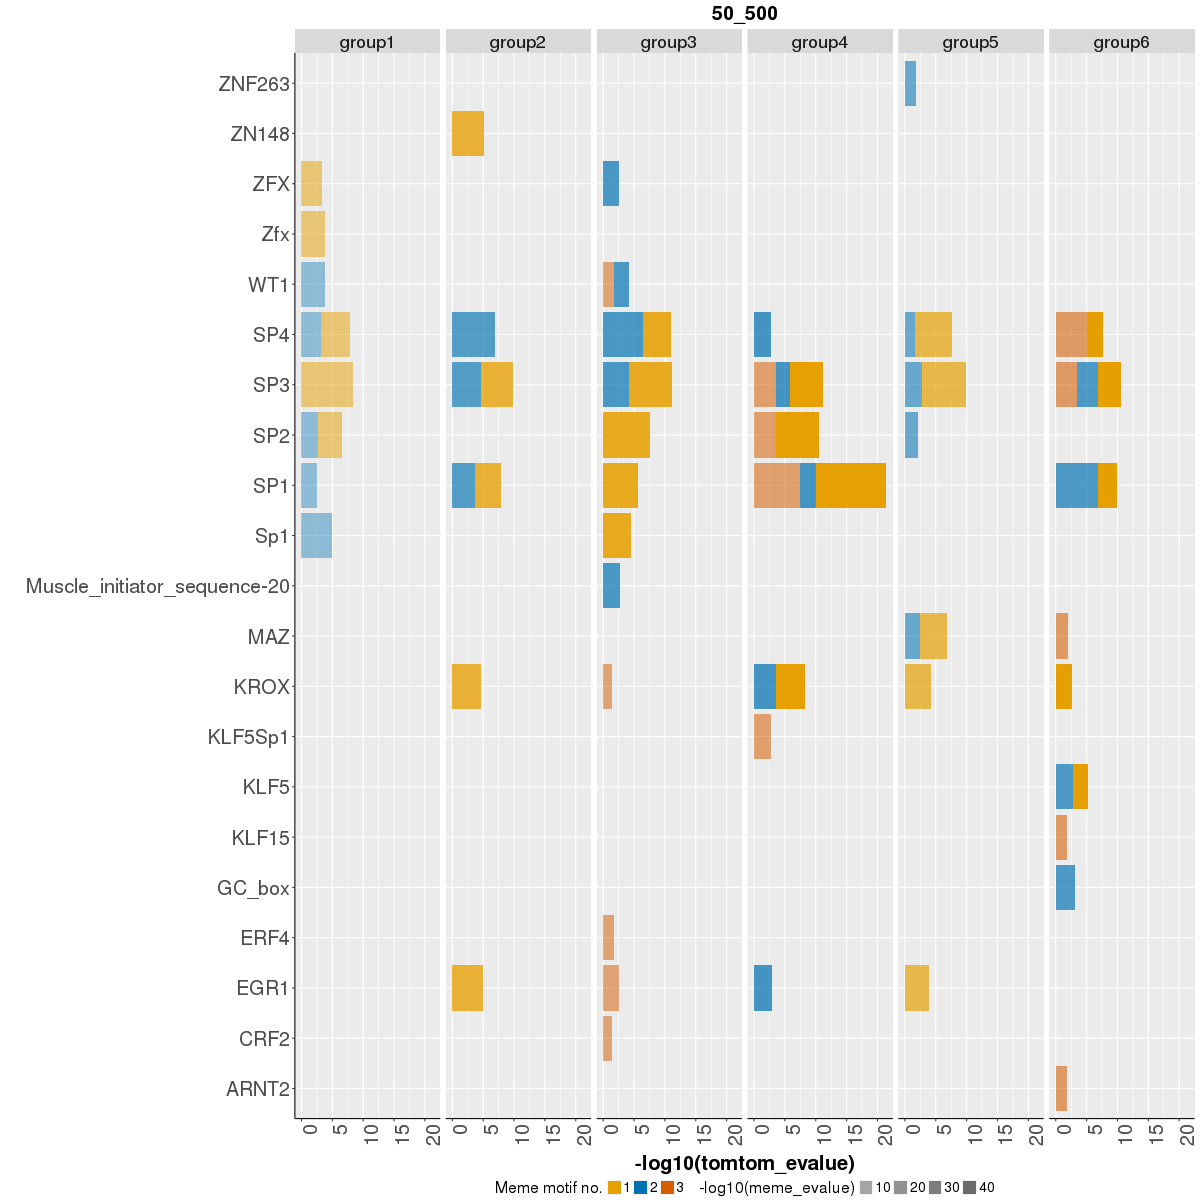

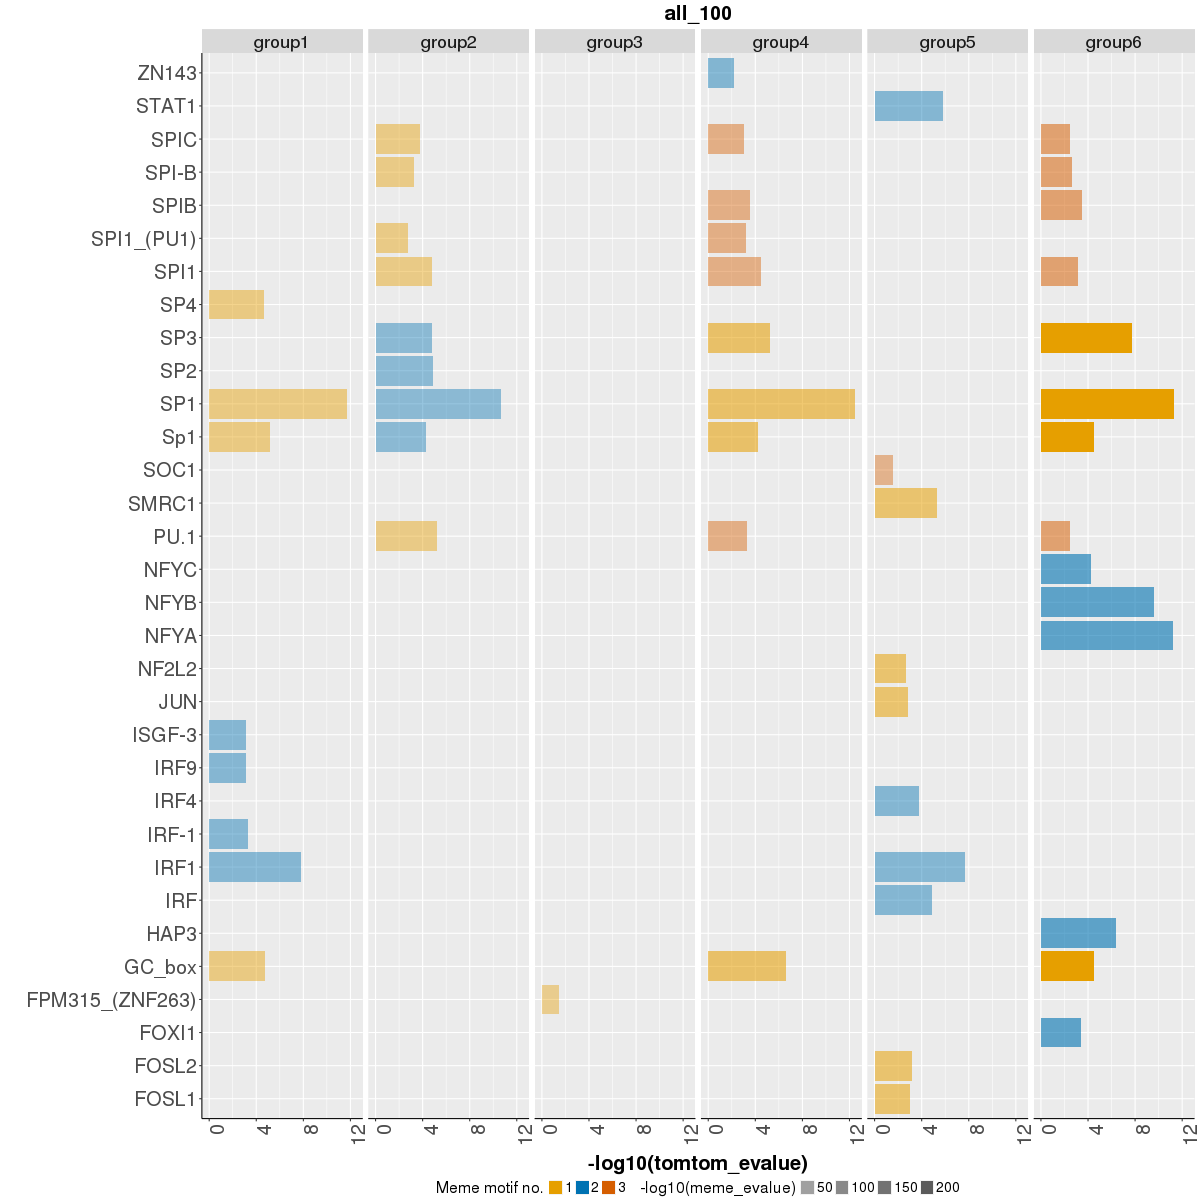

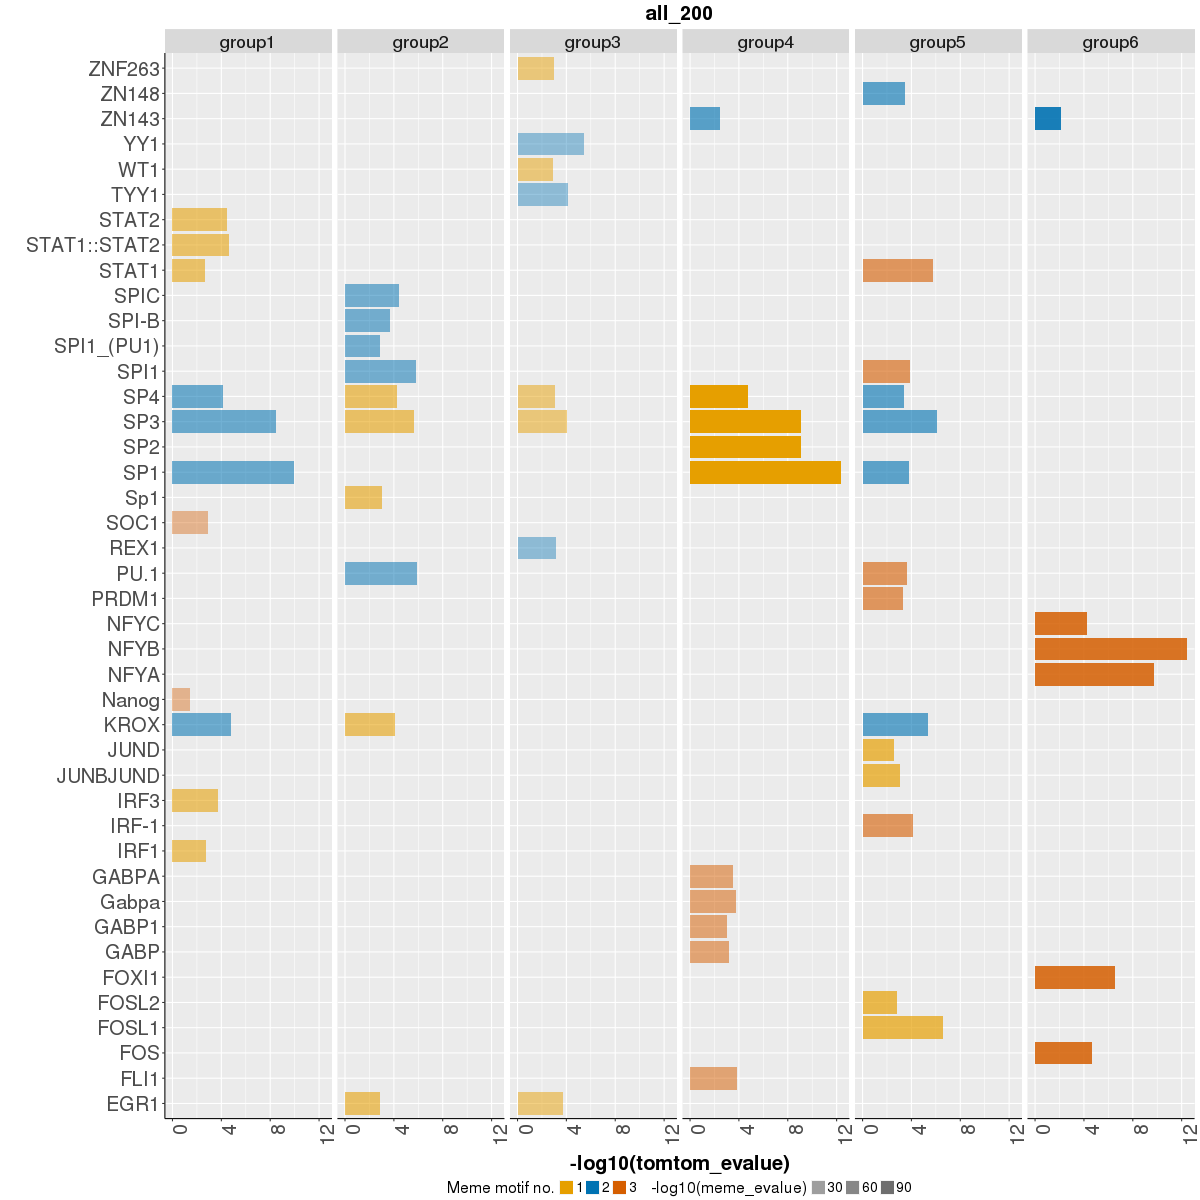

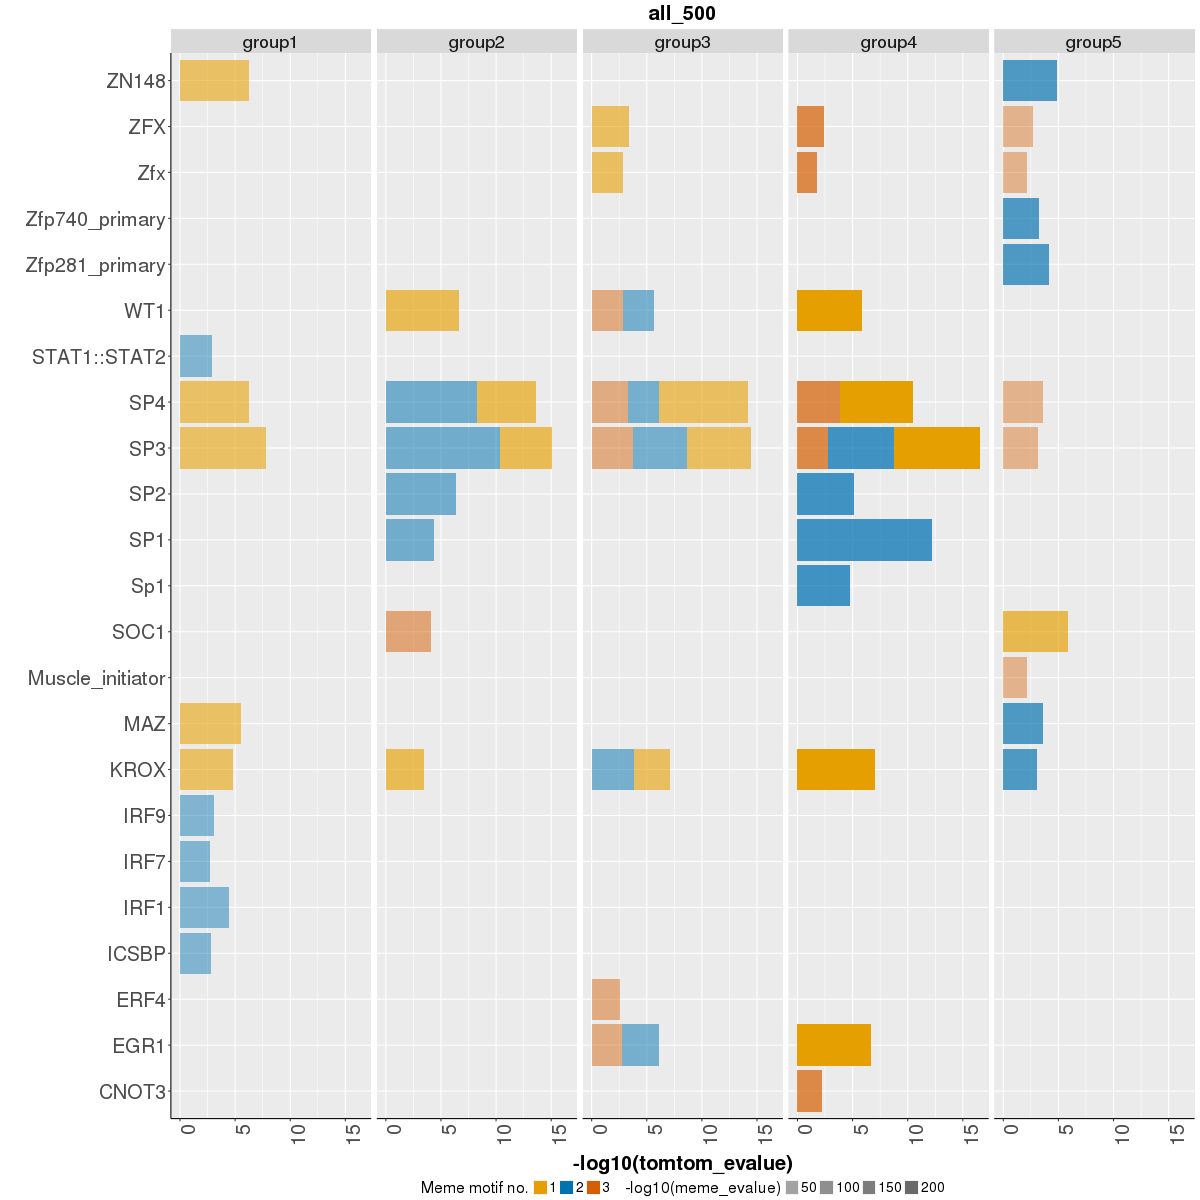

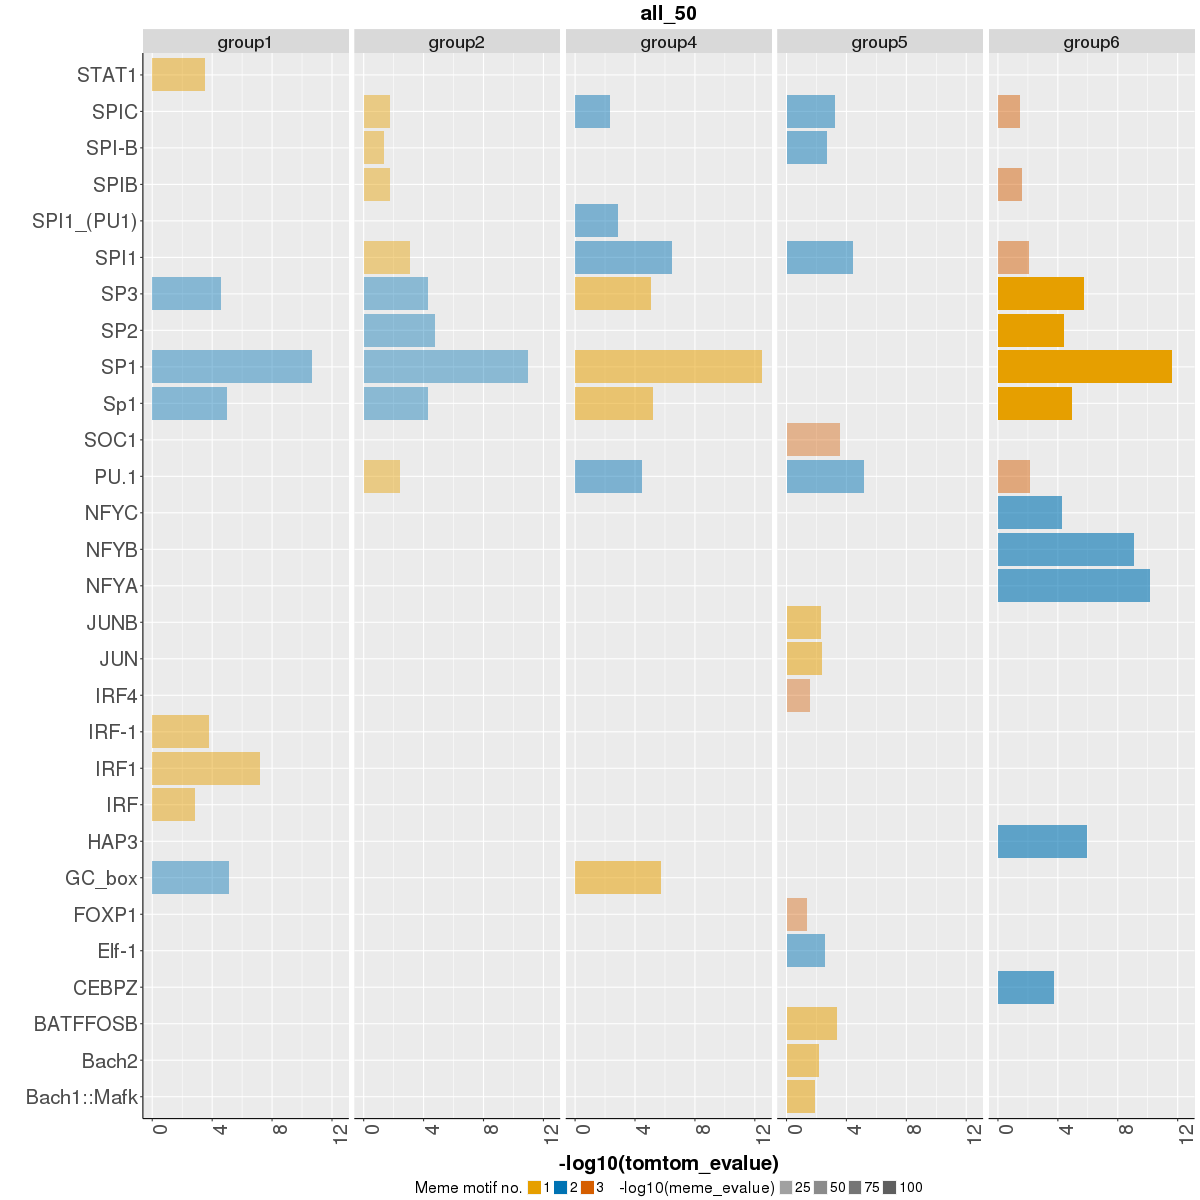

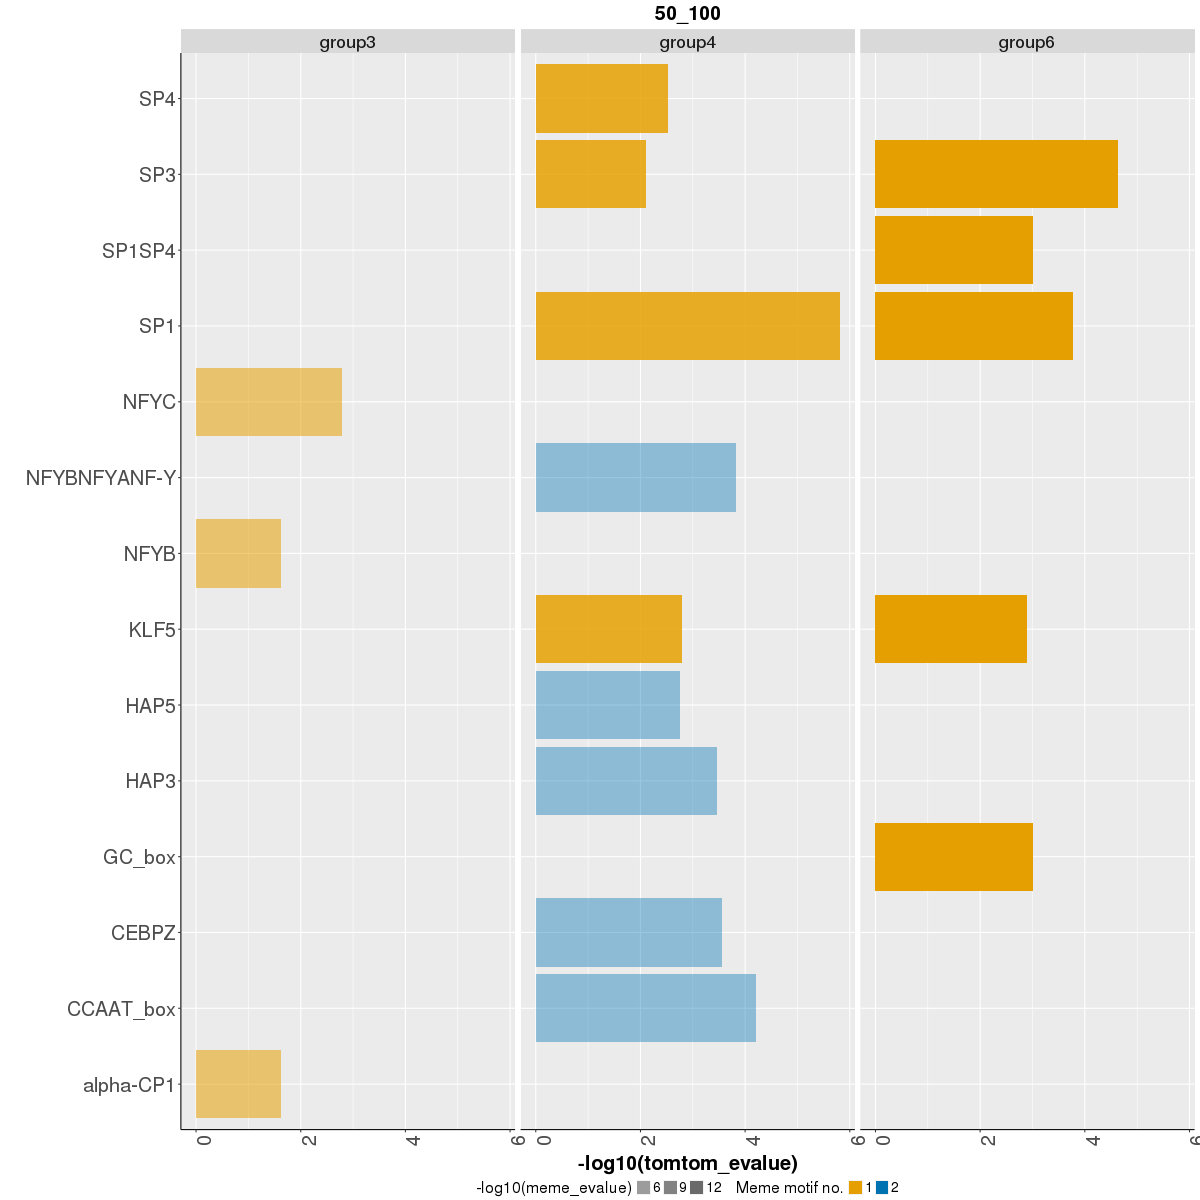

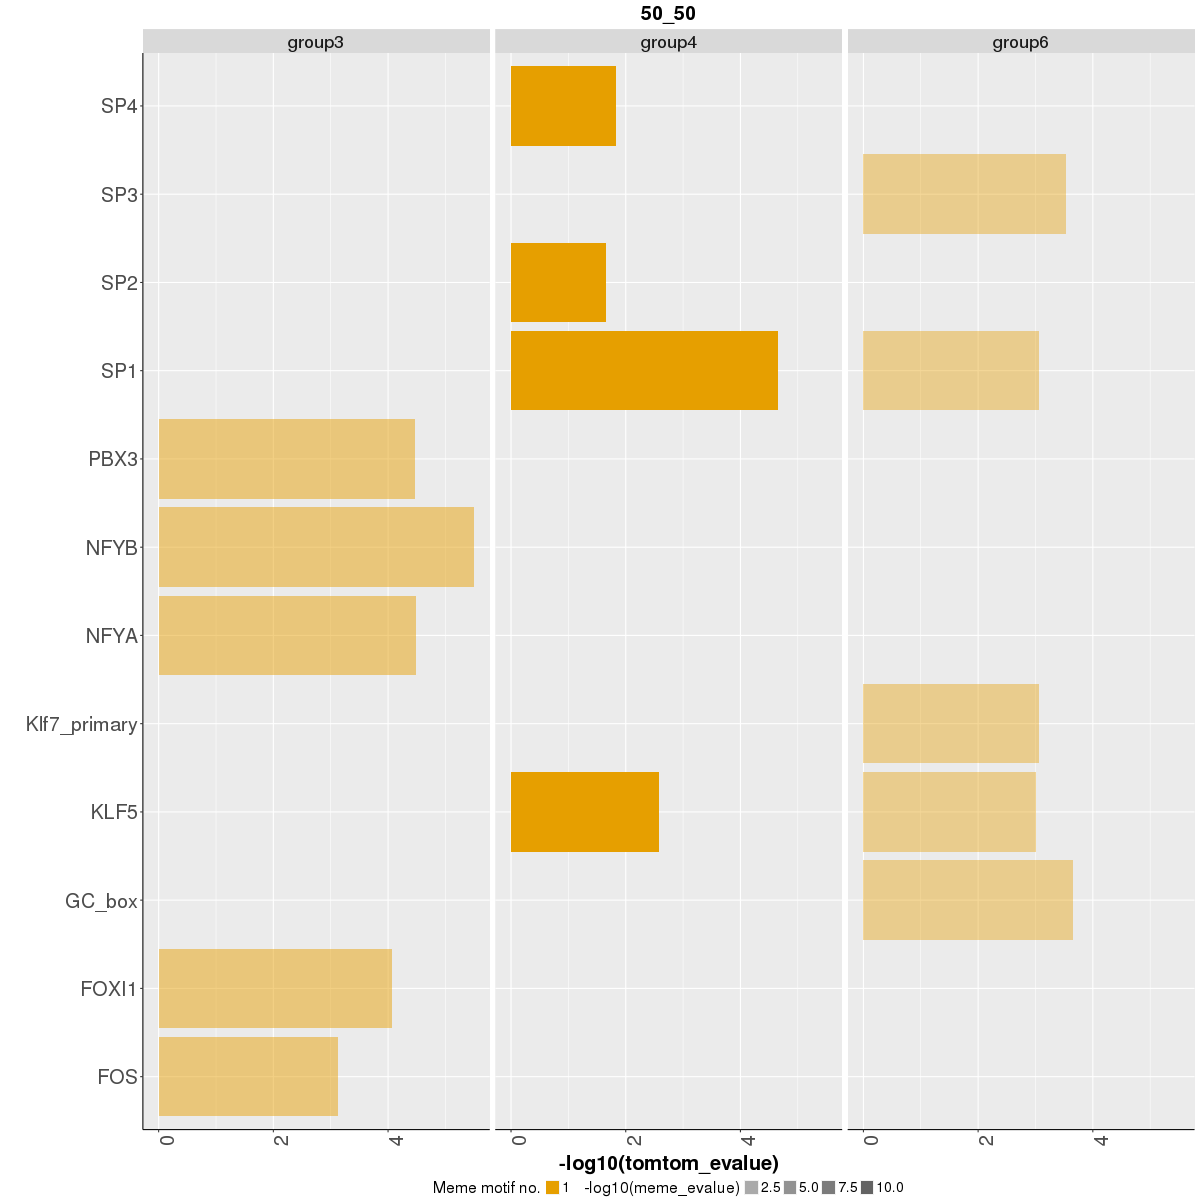

In [55]:
%%R -i tfs -w 1200 -h 1200

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=query_id, alpha=-log10(meme_evalue))) + 
            geom_bar(stat="identity") + 
            coord_flip() +
            scale_alpha(range=c(0.4, 1)) + 
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            theme(axis.text.x=element_text(angle=90, hjust=1)) +
            scale_fill_manual(values=Palette, name = "Meme motif no.") +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}


<br>
## Top Motif Tables:
* Sorted by peak size & TOMTOM e-value

### Peaks with increased accessibility:

In [17]:
for i in meme_chip["DESeq2_comparison"].unique():
    print i
    meme_chip[(meme_chip.DESeq2_comparison == i) & (meme_chip.condition == "increase")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

BMvsMEM


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
12888,9.200000e-42,BMvsMEM_increase_all_100_3,3,AAAAGAAACTGAAACTTAA,IRF1_MOUSE.H10MO.C,IRF1,hocomoco,0.000036,+,BMvsMEM_increase_all_100,BMvsMEM,increase,all,100,all_100
9262,2.200000e-05,BMvsMEM_increase_100_100_1,1,CTGAGTCAT,NFE2_MOUSE.H10MO.A,NFE2,hocomoco,0.000040,-,BMvsMEM_increase_100_100,BMvsMEM,increase,100,100,100_100
9263,2.200000e-05,BMvsMEM_increase_100_100_1,1,CTGAGTCAT,MA0501.1,MAF::NFE2,jaspar,0.000047,-,BMvsMEM_increase_100_100,BMvsMEM,increase,100,100,100_100
9265,2.200000e-05,BMvsMEM_increase_100_100_1,1,CTGAGTCAT,MA0591.1,Bach1::Mafk,jaspar,0.000047,-,BMvsMEM_increase_100_100,BMvsMEM,increase,100,100,100_100
10448,4.500000e-16,BMvsMEM_increase_500_100_2,2,GGGAAAGCGAAACTGA,STAT2_MOUSE.H10MO.B,STAT2,hocomoco,0.000057,-,BMvsMEM_increase_500_100,BMvsMEM,increase,500,100,500_100
10304,1.100000e-60,BMvsMEM_increase_500_100_1,1,CTGAGTCAC,BACH1_MOUSE.H10MO.C,BACH1,hocomoco,0.000089,+,BMvsMEM_increase_500_100,BMvsMEM,increase,500,100,500_100
10449,4.500000e-16,BMvsMEM_increase_500_100_2,2,GGGAAAGCGAAACTGA,M00258,ISGF-3,transfac,0.000101,-,BMvsMEM_increase_500_100,BMvsMEM,increase,500,100,500_100
11670,4.500000e-14,BMvsMEM_increase_1000_100_2,2,AGTTTCAGTTTC,MA0652.1,IRF8,jaspar,0.000129,-,BMvsMEM_increase_1000_100,BMvsMEM,increase,1000,100,1000_100
10452,4.500000e-16,BMvsMEM_increase_500_100_2,2,GGGAAAGCGAAACTGA,IRF3_MOUSE.H10MO.C,IRF3,hocomoco,0.000148,+,BMvsMEM_increase_500_100,BMvsMEM,increase,500,100,500_100
12889,9.200000e-42,BMvsMEM_increase_all_100_3,3,AAAAGAAACTGAAACTTAA,MA0050.2,IRF1,jaspar,0.000192,-,BMvsMEM_increase_all_100,BMvsMEM,increase,all,100,all_100


BLvsMEM


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
3124,8.000000e-12,BLvsMEM_increase_1000_100_2,2,GGGGCGGGGGCGGGGGGGGGGG,SP3_MOUSE.H10MO.B,SP3,hocomoco,2.283530e-08,+,BLvsMEM_increase_1000_100,BLvsMEM,increase,1000,100,1000_100
3125,8.000000e-12,BLvsMEM_increase_1000_100_2,2,GGGGCGGGGGCGGGGGGGGGGG,M00982,KROX,transfac,5.150230e-08,-,BLvsMEM_increase_1000_100,BLvsMEM,increase,1000,100,1000_100
3128,8.000000e-12,BLvsMEM_increase_1000_100_2,2,GGGGCGGGGGCGGGGGGGGGGG,MA0162.2,EGR1,jaspar,1.528210e-07,-,BLvsMEM_increase_1000_100,BLvsMEM,increase,1000,100,1000_100
4590,5.100000e-33,BLvsMEM_increase_all_100_3,3,CCCCCCCCCGCCCCCACCCCCG,SP4_MOUSE.H10MO.D,SP4,hocomoco,2.395530e-07,-,BLvsMEM_increase_all_100,BLvsMEM,increase,all,100,all_100
3130,8.000000e-12,BLvsMEM_increase_1000_100_2,2,GGGGCGGGGGCGGGGGGGGGGG,SP4_MOUSE.H10MO.D,SP4,hocomoco,3.201700e-07,+,BLvsMEM_increase_1000_100,BLvsMEM,increase,1000,100,1000_100
1932,8.400000e-05,BLvsMEM_increase_500_100_2,2,GAAAGCGAAACT,IRF1_MOUSE.H10MO.C,IRF1,hocomoco,2.661270e-06,+,BLvsMEM_increase_500_100,BLvsMEM,increase,500,100,500_100
3131,8.000000e-12,BLvsMEM_increase_1000_100_2,2,GGGGCGGGGGCGGGGGGGGGGG,WT1_MOUSE.H10MO.D,WT1,hocomoco,2.928110e-06,+,BLvsMEM_increase_1000_100,BLvsMEM,increase,1000,100,1000_100
4591,5.100000e-33,BLvsMEM_increase_all_100_3,3,CCCCCCCCCGCCCCCACCCCCG,SP3_MOUSE.H10MO.B,SP3,hocomoco,5.425030e-06,-,BLvsMEM_increase_all_100,BLvsMEM,increase,all,100,all_100
996,2.300000e-02,BLvsMEM_increase_100_100_2,2,AGTTTCACTTTCACTT,MA0050.2,IRF1,jaspar,8.505490e-06,+,BLvsMEM_increase_100_100,BLvsMEM,increase,100,100,100_100
1933,8.400000e-05,BLvsMEM_increase_500_100_2,2,GAAAGCGAAACT,IRF9_MOUSE.H10MO.C,IRF9,hocomoco,1.467770e-05,+,BLvsMEM_increase_500_100,BLvsMEM,increase,500,100,500_100


BMvsAP


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
32774,5.900000e-40,BMvsAP_increase_all_100_2,2,CCCCCCCCCCCCCCCCCACCCC,SP4_MOUSE.H10MO.D,SP4,hocomoco,1.362360e-07,-,BMvsAP_increase_all_100,BMvsAP,increase,all,100,all_100
32775,5.900000e-40,BMvsAP_increase_all_100_2,2,CCCCCCCCCCCCCCCCCACCCC,SP3_MOUSE.H10MO.B,SP3,hocomoco,2.040040e-06,-,BMvsAP_increase_all_100,BMvsAP,increase,all,100,all_100
32776,5.900000e-40,BMvsAP_increase_all_100_2,2,CCCCCCCCCCCCCCCCCACCCC,MAZ_MOUSE.H10MO.D,MAZ,hocomoco,9.881360e-06,-,BMvsAP_increase_all_100,BMvsAP,increase,all,100,all_100
32777,5.900000e-40,BMvsAP_increase_all_100_2,2,CCCCCCCCCCCCCCCCCACCCC,UP00021_1,Zfp281_primary,uniprobe,5.518740e-05,+,BMvsAP_increase_all_100,BMvsAP,increase,all,100,all_100
31614,3.000000e-09,BMvsAP_increase_1000_100_2,2,GGAAACCGAAACTGAA,MA0517.1,STAT1::STAT2,jaspar,5.976370e-05,-,BMvsAP_increase_1000_100,BMvsAP,increase,1000,100,1000_100
31616,3.000000e-09,BMvsAP_increase_1000_100_2,2,GGAAACCGAAACTGAA,STAT2_MOUSE.H10MO.B,STAT2,hocomoco,9.648660e-05,-,BMvsAP_increase_1000_100,BMvsAP,increase,1000,100,1000_100
31617,3.000000e-09,BMvsAP_increase_1000_100_2,2,GGAAACCGAAACTGAA,IRF3_MOUSE.H10MO.C,IRF3,hocomoco,1.007280e-04,+,BMvsAP_increase_1000_100,BMvsAP,increase,1000,100,1000_100
29146,4.700000e-15,BMvsAP_increase_100_100_1,1,TGACTCA,JUNB_MOUSE.H10MO.B,JUNB,hocomoco,1.446870e-04,-,BMvsAP_increase_100_100,BMvsAP,increase,100,100,100_100
28610,3.700000e-07,BMvsAP_increase_50_100_1,1,TGAGTCA,JUNB_MOUSE.H10MO.B,JUNB,hocomoco,1.673470e-04,+,BMvsAP_increase_50_100,BMvsAP,increase,50,100,50_100
31470,1.100000e-192,BMvsAP_increase_1000_100_1,1,TGACTCA,JUN_MOUSE.H10MO.A,JUN,hocomoco,2.502920e-04,-,BMvsAP_increase_1000_100,BMvsAP,increase,1000,100,1000_100


BLvsAP


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
22162,2.600000e-52,BLvsAP_increase_all_100_2,2,CGGGGGGGGGGGGCGGGGGGGG,SP4_MOUSE.H10MO.D,SP4,hocomoco,0.000002,+,BLvsAP_increase_all_100,BLvsAP,increase,all,100,all_100
22163,2.600000e-52,BLvsAP_increase_all_100_2,2,CGGGGGGGGGGGGCGGGGGGGG,SP3_MOUSE.H10MO.B,SP3,hocomoco,0.000003,+,BLvsAP_increase_all_100,BLvsAP,increase,all,100,all_100
19716,9.300000e-05,BLvsAP_increase_500_100_2,2,TTTTACTTTCAGTTTC,MA0050.2,IRF1,jaspar,0.000003,+,BLvsAP_increase_500_100,BLvsAP,increase,500,100,500_100
22164,2.600000e-52,BLvsAP_increase_all_100_2,2,CGGGGGGGGGGGGCGGGGGGGG,M00982,KROX,transfac,0.000038,-,BLvsAP_increase_all_100,BLvsAP,increase,all,100,all_100
22167,2.600000e-52,BLvsAP_increase_all_100_2,2,CGGGGGGGGGGGGCGGGGGGGG,MAZ_MOUSE.H10MO.D,MAZ,hocomoco,0.000087,+,BLvsAP_increase_all_100,BLvsAP,increase,all,100,all_100
22168,2.600000e-52,BLvsAP_increase_all_100_2,2,CGGGGGGGGGGGGCGGGGGGGG,ZN148_MOUSE.H10MO.D,ZN148,hocomoco,0.000128,+,BLvsAP_increase_all_100,BLvsAP,increase,all,100,all_100
19718,9.300000e-05,BLvsAP_increase_500_100_2,2,TTTTACTTTCAGTTTC,IRF1_MOUSE.H10MO.C,IRF1,hocomoco,0.000134,-,BLvsAP_increase_500_100,BLvsAP,increase,500,100,500_100
22169,2.600000e-52,BLvsAP_increase_all_100_2,2,CGGGGGGGGGGGGCGGGGGGGG,UP00021_1,Zfp281_primary,uniprobe,0.000199,-,BLvsAP_increase_all_100,BLvsAP,increase,all,100,all_100
19719,9.300000e-05,BLvsAP_increase_500_100_2,2,TTTTACTTTCAGTTTC,PRDM1_MOUSE.H10MO.A,PRDM1,hocomoco,0.000321,-,BLvsAP_increase_500_100,BLvsAP,increase,500,100,500_100
19720,9.300000e-05,BLvsAP_increase_500_100_2,2,TTTTACTTTCAGTTTC,IRF3_MOUSE.H10MO.C,IRF3,hocomoco,0.000371,-,BLvsAP_increase_500_100,BLvsAP,increase,500,100,500_100


MEMvsAP


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
42380,2.600000e-61,MEMvsAP_increase_1000_100_1,1,TCACTTCCTCTT,M01172,PU.1,transfac,5.169720e-07,+,MEMvsAP_increase_1000_100,MEMvsAP,increase,1000,100,1000_100
40330,1.100000e-07,MEMvsAP_increase_100_100_2,2,AAGAGGAAG,M01172,PU.1,transfac,4.661290e-05,-,MEMvsAP_increase_100_100,MEMvsAP,increase,100,100,100_100
40333,1.100000e-07,MEMvsAP_increase_100_100_2,2,AAGAGGAAG,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,8.573740e-05,+,MEMvsAP_increase_100_100,MEMvsAP,increase,100,100,100_100
40186,2.800000e-06,MEMvsAP_increase_100_100_1,1,TGAGTCA,BATF_MOUSE.H10MO.B,BATF,hocomoco,9.484940e-05,+,MEMvsAP_increase_100_100,MEMvsAP,increase,100,100,100_100
40394,5.000000e-03,MEMvsAP_increase_100_100_3,3,CCCCCCCCCCCA,UP00022_1,Zfp740_primary,uniprobe,2.716310e-04,+,MEMvsAP_increase_100_100,MEMvsAP,increase,100,100,100_100
41395,9.200000e-59,MEMvsAP_increase_500_100_1,1,TCACTTCCTCTT,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,3.193240e-04,-,MEMvsAP_increase_500_100,MEMvsAP,increase,500,100,500_100
40395,5.000000e-03,MEMvsAP_increase_100_100_3,3,CCCCCCCCCCCA,UP00021_1,Zfp281_primary,uniprobe,8.478870e-04,+,MEMvsAP_increase_100_100,MEMvsAP,increase,100,100,100_100
42532,9.900000e-26,MEMvsAP_increase_1000_100_3,3,CTGAGTCA,MA0591.1,Bach1::Mafk,jaspar,9.318770e-04,-,MEMvsAP_increase_1000_100,MEMvsAP,increase,1000,100,1000_100
40334,1.100000e-07,MEMvsAP_increase_100_100_2,2,AAGAGGAAG,UP00085_1,Sfpi1_primary,uniprobe,1.440850e-03,+,MEMvsAP_increase_100_100,MEMvsAP,increase,100,100,100_100
42534,9.900000e-26,MEMvsAP_increase_1000_100_3,3,CTGAGTCA,BACH1_MOUSE.H10MO.C,BACH1,hocomoco,2.373180e-03,+,MEMvsAP_increase_1000_100,MEMvsAP,increase,1000,100,1000_100


### Peaks with decreased accessibility:

In [18]:
for i in meme_chip["DESeq2_comparison"].unique():
    print i
    meme_chip[(meme_chip.DESeq2_comparison == i) & (meme_chip.condition == "decrease")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

BMvsMEM


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
16342,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,0.000011,+,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100
16343,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,M01172,PU.1,transfac,0.000044,-,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100
16346,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,0.000099,-,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100
14298,1.100000e-58,BMvsMEM_decrease_500_100_1,1,CACTTCCTCCTT,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,0.000765,-,BMvsMEM_decrease_500_100,BMvsMEM,decrease,500,100,500_100
14299,1.100000e-58,BMvsMEM_decrease_500_100_1,1,CACTTCCTCCTT,M01172,PU.1,transfac,0.001224,+,BMvsMEM_decrease_500_100,BMvsMEM,decrease,500,100,500_100
16347,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,SPIB_MOUSE.H10MO.B,SPIB,hocomoco,0.002805,+,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100
16348,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,MA0687.1,SPIC,jaspar,0.003409,+,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100
16350,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,M01203,SPI1_(PU1),transfac,0.003646,+,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100
16353,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,MA0508.1,PRDM1,jaspar,0.004943,+,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100
16355,1.100000e-147,BMvsMEM_decrease_all_100_1,1,AGAAAGAGGAAGTGA,M02078,SPI1,transfac,0.009215,+,BMvsMEM_decrease_all_100,BMvsMEM,decrease,all,100,all_100


BLvsMEM


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
5600,1.800000e-70,BLvsMEM_decrease_500_100_1,1,AAGAGGAAGTGA,M01172,PU.1,transfac,0.000009,-,BLvsMEM_decrease_500_100,BLvsMEM,decrease,500,100,500_100
5603,1.800000e-70,BLvsMEM_decrease_500_100_1,1,AAGAGGAAGTGA,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,0.000911,+,BLvsMEM_decrease_500_100,BLvsMEM,decrease,500,100,500_100
6705,2.700000e-106,BLvsMEM_decrease_1000_100_1,1,AAGAGGAAGTGACTGG,M02078,SPI1,transfac,0.010919,+,BLvsMEM_decrease_1000_100,BLvsMEM,decrease,1000,100,1000_100
6706,2.700000e-106,BLvsMEM_decrease_1000_100_1,1,AAGAGGAAGTGACTGG,ELF2_MOUSE.H10MO.C,ELF2,hocomoco,0.015076,+,BLvsMEM_decrease_1000_100,BLvsMEM,decrease,1000,100,1000_100
5605,1.800000e-70,BLvsMEM_decrease_500_100_1,1,AAGAGGAAGTGA,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,0.026115,-,BLvsMEM_decrease_500_100,BLvsMEM,decrease,500,100,500_100
5606,1.800000e-70,BLvsMEM_decrease_500_100_1,1,AAGAGGAAGTGA,UP00085_1,Sfpi1_primary,uniprobe,0.027260,+,BLvsMEM_decrease_500_100,BLvsMEM,decrease,500,100,500_100
5607,1.800000e-70,BLvsMEM_decrease_500_100_1,1,AAGAGGAAGTGA,M00971,Ets,transfac,0.027271,-,BLvsMEM_decrease_500_100,BLvsMEM,decrease,500,100,500_100
6707,2.700000e-106,BLvsMEM_decrease_1000_100_1,1,AAGAGGAAGTGACTGG,M02076,Spi-B,transfac,0.028921,+,BLvsMEM_decrease_1000_100,BLvsMEM,decrease,1000,100,1000_100
5613,1.800000e-70,BLvsMEM_decrease_500_100_1,1,AAGAGGAAGTGA,M02077,Spic,transfac,0.030441,+,BLvsMEM_decrease_500_100,BLvsMEM,decrease,500,100,500_100
5616,1.800000e-70,BLvsMEM_decrease_500_100_1,1,AAGAGGAAGTGA,IRF4_MOUSE.H10MO.C,IRF4,hocomoco,0.031524,+,BLvsMEM_decrease_500_100,BLvsMEM,decrease,500,100,500_100


BMvsAP


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
38202,6.100000e-96,BMvsAP_decrease_all_100_2,2,GGCCCCGCCCCCCCCC,SP3_MOUSE.H10MO.B,SP3,hocomoco,1.020100e-08,-,BMvsAP_decrease_all_100,BMvsAP,decrease,all,100,all_100
36244,3.100000e-56,BMvsAP_decrease_1000_100_2,2,GCCCCGCCCCCT,SP1_MOUSE.H10MO.S,SP1,hocomoco,1.008260e-07,-,BMvsAP_decrease_1000_100,BMvsAP,decrease,1000,100,1000_100
36245,3.100000e-56,BMvsAP_decrease_1000_100_2,2,GCCCCGCCCCCT,M00255,GC_box,transfac,1.802940e-07,-,BMvsAP_decrease_1000_100,BMvsAP,decrease,1000,100,1000_100
38203,6.100000e-96,BMvsAP_decrease_all_100_2,2,GGCCCCGCCCCCCCCC,MA0516.1,SP2,jaspar,2.448730e-07,+,BMvsAP_decrease_all_100,BMvsAP,decrease,all,100,all_100
34558,2.100000e-26,BMvsAP_decrease_500_100_2,2,CCCCGCCCCCCCCCCC,M00933,Sp1,transfac,1.612170e-06,+,BMvsAP_decrease_500_100,BMvsAP,decrease,500,100,500_100
38206,6.100000e-96,BMvsAP_decrease_all_100_2,2,GGCCCCGCCCCCCCCC,SP4_MOUSE.H10MO.D,SP4,hocomoco,2.202070e-06,-,BMvsAP_decrease_all_100,BMvsAP,decrease,all,100,all_100
36248,3.100000e-56,BMvsAP_decrease_1000_100_2,2,GCCCCGCCCCCT,MA0079.3,SP1,jaspar,2.506480e-06,+,BMvsAP_decrease_1000_100,BMvsAP,decrease,1000,100,1000_100
36416,3.700000e-10,BMvsAP_decrease_1000_100_3,3,CCCTCCCCCCCCCCCCCCCCCC,MAZ_MOUSE.H10MO.D,MAZ,hocomoco,4.489110e-06,-,BMvsAP_decrease_1000_100,BMvsAP,decrease,1000,100,1000_100
34561,2.100000e-26,BMvsAP_decrease_500_100_2,2,CCCCGCCCCCCCCCCC,ZN148_MOUSE.H10MO.D,ZN148,hocomoco,4.635980e-06,-,BMvsAP_decrease_500_100,BMvsAP,decrease,500,100,500_100
36417,3.700000e-10,BMvsAP_decrease_1000_100_3,3,CCCTCCCCCCCCCCCCCCCCCC,UP00021_1,Zfp281_primary,uniprobe,1.711500e-05,+,BMvsAP_decrease_1000_100,BMvsAP,decrease,1000,100,1000_100


BLvsAP


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
24240,4.100000e-35,BLvsAP_decrease_500_100_2,2,GGCCCCGCCCCCCGCC,MA0516.1,SP2,jaspar,2.128710e-07,+,BLvsAP_decrease_500_100,BLvsAP,decrease,500,100,500_100
24242,4.100000e-35,BLvsAP_decrease_500_100_2,2,GGCCCCGCCCCCCGCC,SP3_MOUSE.H10MO.B,SP3,hocomoco,2.158790e-07,-,BLvsAP_decrease_500_100,BLvsAP,decrease,500,100,500_100
27728,5.300000e-228,BLvsAP_decrease_all_100_1,1,CCCCCACTTCCTCTTT,M01172,PU.1,transfac,3.393150e-07,+,BLvsAP_decrease_all_100,BLvsAP,decrease,all,100,all_100
27983,2.000000e-92,BLvsAP_decrease_all_100_2,2,GGCCCCGCCCCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,2.105900e-06,-,BLvsAP_decrease_all_100,BLvsAP,decrease,all,100,all_100
26038,3.700000e-55,BLvsAP_decrease_1000_100_2,2,GGGGGCGGGGCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,3.434990e-06,+,BLvsAP_decrease_1000_100,BLvsAP,decrease,1000,100,1000_100
26039,3.700000e-55,BLvsAP_decrease_1000_100_2,2,GGGGGCGGGGCC,SP3_MOUSE.H10MO.B,SP3,hocomoco,1.192190e-05,+,BLvsAP_decrease_1000_100,BLvsAP,decrease,1000,100,1000_100
27984,2.000000e-92,BLvsAP_decrease_all_100_2,2,GGCCCCGCCCCC,MA0079.3,SP1,jaspar,1.334600e-05,+,BLvsAP_decrease_all_100,BLvsAP,decrease,all,100,all_100
26040,3.700000e-55,BLvsAP_decrease_1000_100_2,2,GGGGGCGGGGCC,M00255,GC_box,transfac,1.655580e-05,+,BLvsAP_decrease_1000_100,BLvsAP,decrease,1000,100,1000_100
26043,3.700000e-55,BLvsAP_decrease_1000_100_2,2,GGGGGCGGGGCC,MA0079.3,SP1,jaspar,2.015140e-05,-,BLvsAP_decrease_1000_100,BLvsAP,decrease,1000,100,1000_100
27986,2.000000e-92,BLvsAP_decrease_all_100_2,2,GGCCCCGCCCCC,M00255,GC_box,transfac,2.767560e-05,-,BLvsAP_decrease_all_100,BLvsAP,decrease,all,100,all_100


MEMvsAP


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,condition,no_peaks,window,settings
45796,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,0.000213,-,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45797,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,SP3_MOUSE.H10MO.B,SP3,hocomoco,0.001242,-,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45798,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,M01273,SP4,transfac,0.001280,+,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45799,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,MA0079.3,SP1,jaspar,0.002318,+,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45801,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,M00255,GC_box,transfac,0.003019,-,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45804,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,MA0599.1,KLF5,jaspar,0.003032,+,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45806,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,MA0039.2,Klf4,jaspar,0.005650,-,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45808,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,MA0516.1,SP2,jaspar,0.007746,+,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45810,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,M01588,GKLF_(KLF4),transfac,0.013229,+,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
45813,1.100000e-08,MEMvsAP_decrease_500_100_1,1,GCCCCGCCC,MA0741.1,KLF16,jaspar,0.016446,+,MEMvsAP_decrease_500_100,MEMvsAP,decrease,500,100,500_100
